In [19]:
%matplotlib notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython
import itertools, os, sys

sys.path.append('..')
from data.load_data import *
from src.map import *
from src.robot import *
from src.slam import *
from src.utils import *

In [79]:
import pickle

MAP_XLIM = (-15, 15)
MAP_YLIM = (-15, 15)
MAP_RESOLUTION = 0.05

belief = 0.8
MAP_LOGODDS_OCCUPIED_DIFF = np.log(belief/(1-belief))
MAP_LOGODDS_FREE_DIFF = np.log((1-belief)/belief)*.5
MAP_LOGODDS_LIM = (-100, 100)

N_PARTICLES = 128
N_EFF_THRESHOLD = 4
PREDICT_NOISE_SIGMA = np.diag([1e-3, 1e-3, 1e-3])
MAP_LOGODDS_OCCUPIED_THRESHOLD = np.log(9)

SAVE_MAP_FIG_FNAME_TEMPLATE = '../fig/MAP_0/{}.jpg'
SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE = '../fig/MAP_TEXTURE_0/{}.jpg'
# SAVE_MAP_FIG_FNAME_TEMPLATE = None
# SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE = None

with open('../data/train0.pkl', 'rb') as f:
    datas = pickle.load(f)

In [14]:
from multiprocessing import Pool
import cv2

logodds = Map2D(xlim=MAP_XLIM, ylim=MAP_YLIM, resolution=MAP_RESOLUTION)

state = { 'x': 0, 'y': 0, 'theta': 0 }
for di, data in enumerate(datas):
    for i, key in enumerate(['x', 'y', 'theta']):
        state[key] += data['lidar_delta_pose'][0, i]
        
    if di % 1 == 0:
        lidar_scan = data['lidar_scan']
        lidar_scan_points = np.hstack([data['lidar_scan_points'], np.ones((data['lidar_scan_points'].shape[0], 1))])
        t = Transform(**state, **data)
        lidar_scan_points_w = t.chain('wTb', 'bTh', 'hTl') @ lidar_scan_points.T
        lidar_scan_points_w = lidar_scan_points_w.T[:, :3]
        lidar_scan_points_w = lidar_scan_points_w[lidar_scan_points_w[:, 2] > 0.1, :]
        lidar_scan_points_w = lidar_scan_points_w[logodds.in_map(lidar_scan_points_w), :2]
        
        lidar_scan_indices = logodds.coordinate_to_index(lidar_scan_points_w)
        
        mask = cv2.drawContours(image=np.zeros_like(logodds.data), 
                                contours=[lidar_scan_indices.reshape((-1,1,2)).astype(np.int32)], 
                                contourIdx =-1, 
                                color = MAP_LOGODDS_FREE_DIFF, 
                                thickness=-1)
        logodds.data += mask
        logodds.data[lidar_scan_indices[:, 1], lidar_scan_indices[:, 0]] += MAP_LOGODDS_OCCUPIED_DIFF - MAP_LOGODDS_FREE_DIFF
        logodds.data = np.clip(logodds.data, *MAP_LOGODDS_LIM)
    
    
logodds.data.max()

100.0

1.0 0.0
(601, 601)
475


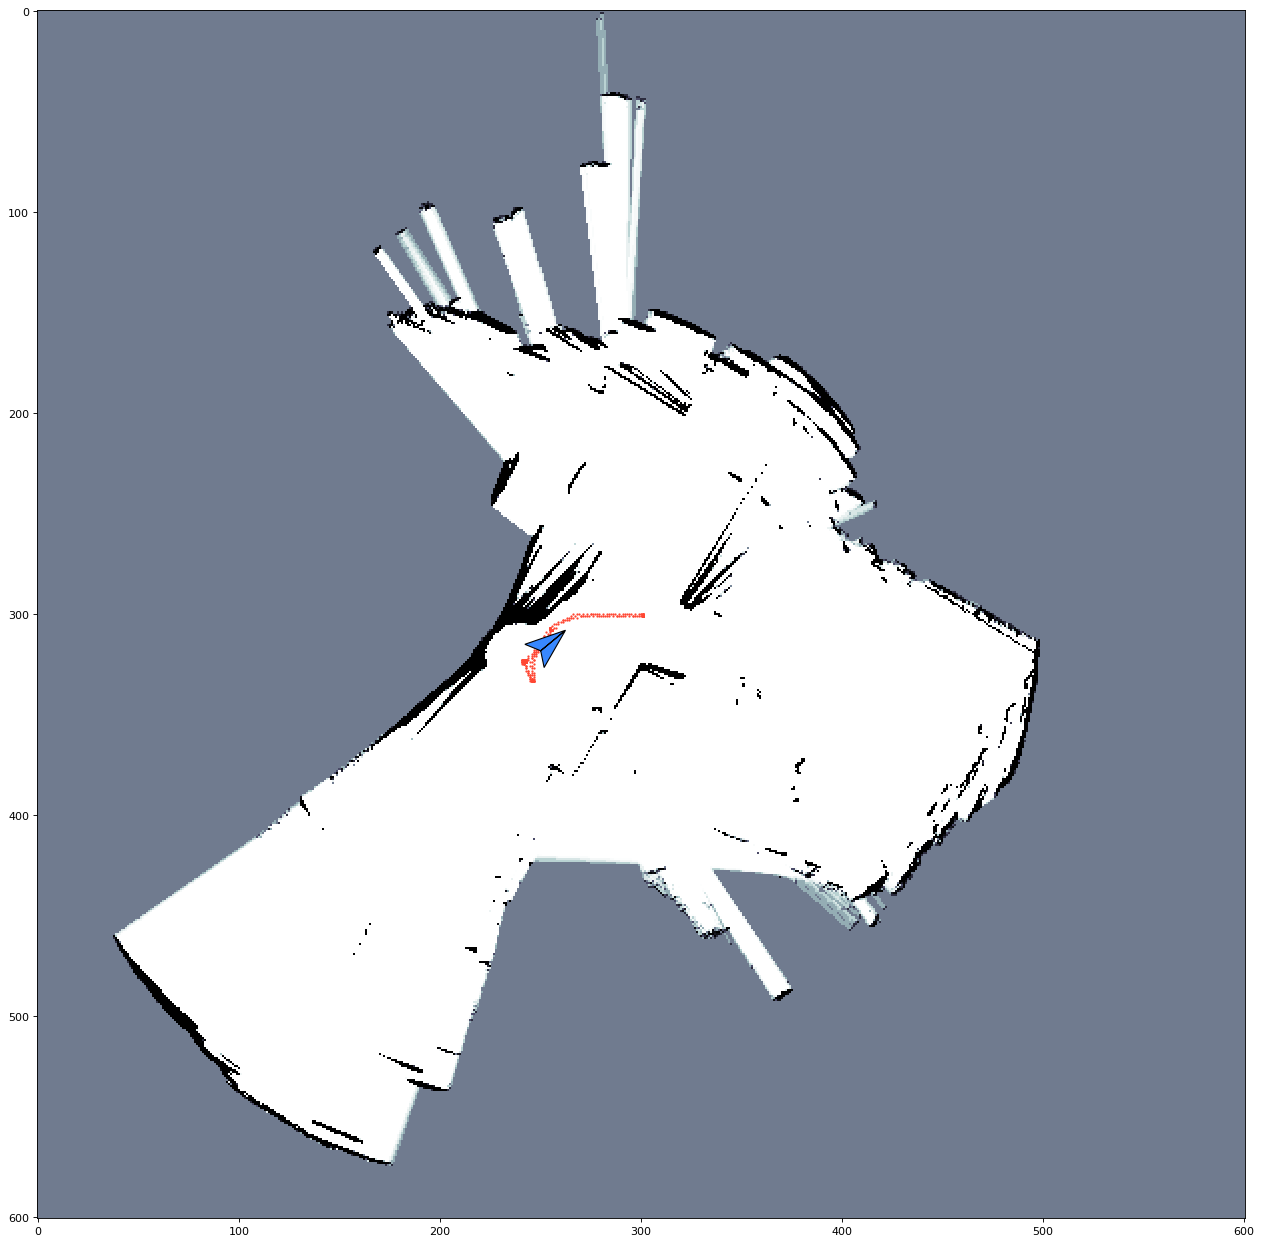

In [69]:
%autoreload 2
from src.utils import *

gamma = 1.0 - 1.0/(1.0 + np.exp(logodds.data))
print(gamma.max(), gamma.min())
print(logodds.data.shape)

state = np.array([0, 0, 0], dtype=np.float64)
posx = []
posy = []

for i, data in enumerate(datas[:9500]):
    state[0] += data['lidar_delta_pose'][0, 0]
    state[1] += data['lidar_delta_pose'][0, 1]
    state[2] += data['lidar_delta_pose'][0, 2]
    
    x, y = logodds.coordinate_to_index([state[0], state[1]]).reshape(-1)
    if i % 20 == 0:
        posx.append(x)
        posy.append(y)

plot_map(1-gamma, [posx, posy], figsize=20, show_navigation=True, navigation_heading=state[2])

In [89]:
%load_ext autoreload
%autoreload 2
from src.slam import ParticleFilterSLAM

slam = ParticleFilterSLAM(
    n_particles=N_PARTICLES,
    n_efficient_threshold=N_EFF_THRESHOLD,
    map_xlim=MAP_XLIM,
    map_ylim=MAP_YLIM,
    map_resolution=MAP_RESOLUTION,
    map_logodds_lim=MAP_LOGODDS_LIM,
    map_logodds_occupied_diff=MAP_LOGODDS_OCCUPIED_DIFF,
    map_logodds_free_diff=MAP_LOGODDS_FREE_DIFF,
    map_logodds_occupied_threshold=MAP_LOGODDS_OCCUPIED_THRESHOLD,
    predict_noise_sigma=PREDICT_NOISE_SIGMA
)

states = [np.array([0, 0, 0])]
for i, data in enumerate(datas):
    with slam.set_robot_data(**data):
        u = slam.predict_particles(data['lidar_delta_pose'][0, :])
        corr, neff = slam.update_particles()

        states.append(slam.robot_state)

        if i % 1 == 0:
            print(i, slam.robot_state, neff, corr.max(), corr.min())
            slam.update_map_logodds()
        
        if i % 10 == 0:
            slam.update_map_texture()
        
        if i % 50 == 0 and  i > 0:
            if SAVE_MAP_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                plot_map(1.0 - slam.map_prob, save_fig_name=fname, 
                             show_navigation=True, navigation_heading=states[-1][2],
                             pos=[indices[::5, 0], indices[::5, 1]], )
                
            if SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE is not None:
                fname = SAVE_MAP_TEXTURE_FIG_FNAME_TEMPLATE.format(i)

                indices = slam.coordinate_to_map_index(np.array(states))
                plot_map(slam.map_texture_trimmed, save_fig_name=fname,
                             show_navigation=True, navigation_heading=states[-1][2],
                             pos=[indices[::5, 0], indices[::5, 1]], )
            
        plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
0 [-0.09844282 -0.10100141  0.00033584] 127.99999999999997 0.0 0.0
1 [-0.19754695 -0.19931712  0.00600748] 127.99999999999997 0.0 0.0
2 [-1.56623198e-01 -1.68022039e-01 -1.23184855e-05] 6.244441044582703 15.0 4.0
3 [-0.14533111 -0.16792234 -0.00224415] 1.0000000000013642 258.0 18.0
4 [-0.14959869 -0.18170377 -0.00194694] 1.6480542736683284 482.0 80.0
5 [-0.14984078 -0.1728429  -0.00055924] 1.0000125135996438 716.0 141.0
6 [-0.15086673 -0.17454131 -0.00089442] 1.0000006118149058 776.0 143.0
7 [-0.14245343 -0.19325301 -0.00020512] 1.0018237624145936 735.0 136.0
8 [-0.14570726 -0.17942744 -0.00391567] 1.0000000001032276 769.0 167.0
9 [-0.12913755 -0.17499002 -0.00082446] 1.0049759917780734 731.0 143.0
10 [-0.14105602 -0.1716008  -0.00339757] 1.0013420865685927 750.0 137.0
11 [-1.38913472e-01 -1.90778657e-01  6.47847257e-05] 1.000000000763066 762.0 161.0
12 [-0.1267278  -0.17665723 -0.0025975 ] 1.099327

115 [-0.11959543 -0.21228309 -0.00622139] 1.041918911482171 765.0 141.0
116 [-0.13031663 -0.20258287 -0.00610171] 1.0009178275747241 766.0 142.0
117 [-0.1163219  -0.18633828 -0.00936329] 1.0993279391538826 743.0 141.0
118 [-0.12814869 -0.19617271 -0.00557104] 1.2660774248479165 753.0 116.0
119 [-0.12679169 -0.21645624 -0.00799179] 1.101251516652523 745.0 141.0
120 [-0.11674    -0.19118274 -0.00966526] 1.000671379605945 754.0 130.0
121 [-0.11756234 -0.18968451 -0.00701896] 1.0018237639325753 763.0 134.0
122 [-0.12219218 -0.19582408 -0.00625628] 1.0004936808980183 772.0 127.0
123 [-0.12326131 -0.19756898 -0.00499783] 1.0018237624148214 758.0 133.0
124 [-0.11500876 -0.20559962 -0.00505118] 1.000033639681429 756.0 115.0
125 [-0.12165059 -0.19749548 -0.00726477] 1.266665192572221 772.0 138.0
126 [-0.12228586 -0.19352658 -0.0094941 ] 1.0018272990137769 757.0 126.0
127 [-0.12299891 -0.21131534 -0.00688732] 1.0000045206587562 761.0 131.0
128 [-0.12248596 -0.21505956 -0.00501605] 1.013475282221

229 [-0.11115213 -0.19131756 -0.00946926] 1.0416950416667479 754.0 145.0
230 [-0.11893759 -0.20929208 -0.00615248] 1.0004953679255002 766.0 159.0
231 [-0.1156236  -0.19149194 -0.00724733] 1.0366206864232208 756.0 134.0
232 [-0.10892263 -0.20224097 -0.00794504] 1.0000000001509761 765.0 148.0
233 [-0.11776765 -0.19852795 -0.01159048] 1.000181603850892 745.0 108.0
234 [-0.12942752 -0.20840406 -0.00723433] 1.691984161602038 757.0 150.0
235 [-0.11548432 -0.2096065  -0.00727915] 1.0018238468104073 763.0 152.0
236 [-0.11800088 -0.20178053 -0.0079688 ] 2.0000006422644843 773.0 142.0
237 [-0.11897253 -0.21270852 -0.00650012] 1.000676059366426 764.0 164.0
238 [-0.12278046 -0.20097264 -0.01110877] 1.37594272517162 747.0 145.0
239 [-0.12403701 -0.20866359 -0.00604899] 1.0000016935276255 765.0 151.0
240 [-0.12975413 -0.21379985 -0.00722118] 1.0000145635064914 758.0 156.0
241 [-0.11641166 -0.19259744 -0.00839144] 1.0 764.0 114.0
242 [-0.12551463 -0.20023573 -0.00650332] 1.0049620061453584 765.0 166.

343 [-0.11408613 -0.19024644 -0.00752423] 1.0018255211050644 729.0 138.0
344 [-0.12994997 -0.2084874  -0.00863947] 1.0162383353550246 729.0 155.0
345 [-0.11799625 -0.2139155  -0.00663626] 1.0000168091111883 741.0 109.0
346 [-0.11922904 -0.2023006  -0.00617138] 2.000246895633786 739.0 153.0
347 [-0.11276051 -0.21130069 -0.01058271] 1.0002474367232195 716.0 166.0
348 [-0.10482524 -0.21225725 -0.00790078] 1.0000907998596522 715.0 145.0
349 [-0.11362475 -0.21688748 -0.00790362] 1.0006710085927308 728.0 135.0
350 [-0.1096757  -0.19977551 -0.00849684] 1.0137237533972878 736.0 146.0
351 [-0.12011937 -0.2024796  -0.00998665] 1.0006710192175239 728.0 139.0
352 [-0.12246432 -0.21237335 -0.00732205] 1.6702630491120019 730.0 157.0
353 [-0.11842341 -0.2025602  -0.01014601] 1.0134755087988967 723.0 119.0
354 [-0.10531906 -0.21039611 -0.00844923] 1.64805501578145 707.0 142.0
355 [-0.11889125 -0.19715732 -0.00885701] 1.0000955458322194 730.0 116.0
356 [-0.11582358 -0.1893945  -0.00939658] 1.0000000069

457 [-0.11175226 -0.20021295 -0.00649962] 1.0000380898538963 757.0 140.0
458 [-0.11547984 -0.20173225 -0.00657726] 1.000670925259656 761.0 132.0
459 [-0.11910757 -0.20896065 -0.00812273] 1.0503348222891438 755.0 146.0
460 [-0.11422387 -0.19499554 -0.0073158 ] 1.766350448946052 759.0 155.0
461 [-0.10750488 -0.18646346 -0.00988885] 1.0007046808693159 741.0 153.0
462 [-0.11065143 -0.20100881 -0.01012873] 1.000091505701556 754.0 145.0
463 [-0.11544027 -0.20575684 -0.00740931] 1.0416653504024835 757.0 126.0
464 [-0.11975505 -0.20577939 -0.00871384] 1.3759039044276289 756.0 121.0
465 [-0.11130944 -0.19688364 -0.01006236] 1.0 748.0 142.0
466 [-0.11777644 -0.19076367 -0.00770834] 1.6480945554357285 734.0 173.0
467 [-0.11715926 -0.21146106 -0.00832362] 1.0000000000793534 747.0 119.0
468 [-0.12552527 -0.20222465 -0.00819138] 1.0050484988144857 748.0 133.0
469 [-0.10912055 -0.19322298 -0.00994374] 1.0366189950174205 744.0 135.0
470 [-0.12544188 -0.20110771 -0.00617732] 1.0000380069643995 750.0 16

571 [-0.11793273 -0.20447129 -0.00613875] 1.0000016636167959 761.0 163.0
572 [-0.11574521 -0.2001518  -0.00598213] 1.0135213413594628 751.0 159.0
573 [-0.12203925 -0.20531294 -0.0102314 ] 1.2658091232492688 757.0 132.0
574 [-0.11628829 -0.20478718 -0.00750638] 1.0000002250981324 777.0 153.0
575 [-0.11126295 -0.19832213 -0.00844927] 1.0099271751419656 771.0 155.0
576 [-0.11694399 -0.21329849 -0.00907403] 1.2659037134411246 768.0 110.0
577 [-0.11418799 -0.21997624 -0.00948074] 1.0134753241662884 761.0 162.0
578 [-0.116026   -0.19186823 -0.00664608] 2.004966731843989 750.0 130.0
579 [-0.12807404 -0.20316289 -0.00586868] 1.2658091481769256 738.0 146.0
580 [-0.10758321 -0.20309845 -0.00830481] 1.0000000416698647 769.0 140.0
581 [-0.11549034 -0.21141648 -0.0096733 ] 2.00000062302048 765.0 148.0
582 [-0.11015926 -0.20241052 -0.00628016] 1.1187543895561318 758.0 145.0
583 [-0.11687002 -0.20891608 -0.00819456] 1.0000129837968086 776.0 128.0
584 [-0.10393351 -0.21324024 -0.01228146] 1.2659085152

684 [-0.11506801 -0.20908111 -0.00967437] 1.0367160274278306 767.0 147.0
685 [-0.11882058 -0.21237327 -0.00866938] 1.000000165878429 770.0 124.0
686 [-0.11634517 -0.20509006 -0.00968746] 1.0000334338899952 768.0 149.0
687 [-0.12030461 -0.20922116 -0.00873557] 1.265802228918169 766.0 152.0
688 [-0.11182521 -0.21383907 -0.00833556] 1.265807269211574 762.0 156.0
689 [-0.11422959 -0.20668339 -0.00881854] 1.00495751622148 773.0 142.0
690 [-0.11425897 -0.21237495 -0.00875579] 1.0405899953022109 772.0 114.0
Updating map texture......
691 [-0.10633686 -0.19989544 -0.00854184] 1.099470949295555 756.0 149.0
692 [-0.10972965 -0.20685903 -0.00878612] 1.265807269066805 771.0 144.0
693 [-0.10725049 -0.20910407 -0.0071716 ] 1.2660843027948652 761.0 147.0
694 [-0.11655432 -0.20528632 -0.00956123] 1.0000000000038654 767.0 122.0
695 [-0.1241182  -0.21486703 -0.00972229] 1.0002468196044259 765.0 165.0
696 [-0.11320253 -0.20134455 -0.00839736] 1.0049921866383724 773.0 147.0
697 [-0.10842322 -0.203377   -0

793 [-0.10898779 -0.20284777 -0.0129742 ] 1.0000000128263766 741.0 145.0
794 [-0.11556793 -0.20738991 -0.00780401] 1.0000006118801619 759.0 116.0
795 [-0.11736176 -0.21946932 -0.01040607] 1.000000255534607 741.0 159.0
796 [-0.10816622 -0.20892805 -0.00919845] 1.9590718347012772 750.0 149.0
797 [-0.12217765 -0.2131136  -0.00903753] 1.0000907998596522 752.0 133.0
798 [-0.11655457 -0.20034964 -0.01134014] 1.001008669094781 740.0 161.0
799 [-0.11461798 -0.21032965 -0.00839908] 1.0018282871920081 763.0 141.0
800 [-0.12054242 -0.2148402  -0.01042428] 2.3781815588638664 743.0 153.0
Updating map texture......
801 [-0.12035858 -0.21509652 -0.01109079] 1.013487766900433 750.0 140.0
802 [-0.11849884 -0.21665158 -0.01230135] 1.000673294918652 735.0 131.0
803 [-0.11951264 -0.20640289 -0.00860209] 1.0018237667024814 758.0 135.0
804 [-0.11514771 -0.21060107 -0.00796285] 1.0002802278909122 763.0 149.0
805 [-0.12298293 -0.20204512 -0.00811624] 1.7663581675478286 746.0 134.0
806 [-0.10551952 -0.20196916

903 [-0.10633648 -0.211716   -0.00857171] 1.0074606055082393 757.0 138.0
904 [-0.11343345 -0.21141116 -0.00621434] 1.0366235953886094 762.0 129.0
905 [-0.12466528 -0.2113729  -0.00787648] 1.0 762.0 138.0
906 [-0.10962817 -0.19991054 -0.00658923] 1.0384801472885758 752.0 143.0
907 [-0.10162686 -0.20928909 -0.00979084] 1.0000000304598873 749.0 130.0
908 [-0.11636819 -0.20733491 -0.00728322] 1.0000000828304128 776.0 130.0
909 [-0.10801713 -0.21279286 -0.00568184] 1.0067874215717711 756.0 171.0
910 [-0.10736522 -0.20483559 -0.01118388] 1.000090799863063 759.0 157.0
Updating map texture......
911 [-0.11070989 -0.20726003 -0.0063318 ] 1.0049750323324367 760.0 129.0
912 [-0.11708954 -0.20058265 -0.00945233] 1.0371215349625478 763.0 120.0
913 [-0.12222755 -0.21178144 -0.00893543] 1.0000350664872992 765.0 151.0
914 [-0.11787399 -0.20110789 -0.00788881] 1.0000000000102318 767.0 147.0
915 [-0.11152356 -0.21140518 -0.01090949] 1.0000016678238979 763.0 118.0
916 [-0.12060596 -0.19126495 -0.01058425

1013 [-0.11969515 -0.20627934 -0.01054366] 2.378227435517711 758.0 150.0
1014 [-0.11748723 -0.21446622 -0.01089127] 2.0013435363942507 756.0 136.0
1015 [-0.11731095 -0.21138414 -0.00835932] 2.000246894795129 762.0 125.0
1016 [-0.11762801 -0.20451422 -0.00815578] 1.000000207264538 768.0 144.0
1017 [-0.11625572 -0.20431911 -0.00931075] 1.0000000005882157 762.0 125.0
1018 [-0.10389617 -0.20830205 -0.00982426] 1.002070806870306 751.0 135.0
1019 [-0.11130167 -0.2157638  -0.00961052] 1.000000113344645 755.0 154.0
1020 [-0.12211059 -0.20798389 -0.00884776] 1.0000456920593135 749.0 154.0
Updating map texture......
1021 [-0.11641191 -0.20848942 -0.01094759] 1.0000125150232484 758.0 137.0
1022 [-0.11494668 -0.2144299  -0.00744856] 2.0134528887287253 761.0 104.0
1023 [-0.12214664 -0.21010588 -0.00728964] 1.0004936697368765 768.0 131.0
1024 [-0.11759541 -0.20672234 -0.01165037] 1.0000334042681274 756.0 128.0
1025 [-0.1163872  -0.2152459  -0.00905303] 1.0000340983768876 770.0 142.0
1026 [-0.1166608

1121 [-0.10706624 -0.21496622 -0.01035323] 1.1064340979761178 756.0 116.0
1122 [-0.11212121 -0.20521713 -0.00746386] 1.0007662795361096 765.0 157.0
1123 [-0.11562846 -0.21561382 -0.00694761] 1.0153120822933024 763.0 133.0
1124 [-0.12549822 -0.21320704 -0.00944725] 1.0000008385968793 753.0 154.0
1125 [-0.1181026  -0.19923262 -0.00963217] 1.0366210006032086 756.0 137.0
1126 [-0.11813398 -0.21604141 -0.00734441] 1.7663505660717618 755.0 129.0
1127 [-0.10318588 -0.20961528 -0.00912523] 1.000095545882701 757.0 131.0
1128 [-0.11602721 -0.22192999 -0.00889932] 1.8287271007922778 747.0 142.0
1129 [-0.12001416 -0.20124354 -0.01021488] 1.0000051324648314 758.0 132.0
1130 [-0.11191682 -0.21638348 -0.00916312] 1.000000611804674 771.0 160.0
Updating map texture......
1131 [-0.11049047 -0.20112556 -0.00864576] 1.2717052158994073 768.0 139.0
1132 [-0.11350674 -0.21482377 -0.01016972] 1.014150707164013 764.0 139.0
1133 [-0.10378247 -0.21009587 -0.00763743] 1.656348982969914 750.0 154.0
1134 [-0.106588

1229 [-0.11198672 -0.21283685 -0.00736909] 1.1000352388165187 762.0 119.0
1230 [-0.12155998 -0.2206832  -0.01014107] 2.4208671258553243 739.0 146.0
Updating map texture......
1231 [-0.11192565 -0.20595944 -0.0118402 ] 1.6642637962788038 753.0 126.0
1232 [-0.11659636 -0.20576909 -0.00992464] 1.0000000000277396 756.0 125.0
1233 [-0.11708482 -0.21371386 -0.00820967] 1.0153112400491207 760.0 148.0
1234 [-0.11162128 -0.19578285 -0.00889744] 1.0366189938466994 743.0 135.0
1235 [-0.10859323 -0.20357065 -0.0135044 ] 1.2713415175826817 740.0 150.0
1236 [-0.11053594 -0.20151252 -0.00858652] 1.000000000557975 754.0 131.0
1237 [-0.10692675 -0.2064298  -0.00759854] 1.0020708070616957 743.0 127.0
1238 [-0.11710213 -0.21446995 -0.01058458] 1.0000000002821707 753.0 159.0
1239 [-0.10472421 -0.20900795 -0.00841981] 1.271327787227222 754.0 148.0
1240 [-0.10589701 -0.20566157 -0.01266179] 1.0000000015170372 739.0 123.0
Updating map texture......
1241 [-0.11609433 -0.20853501 -0.01001497] 1.000247056467569

1337 [-0.10449536 -0.22259316 -0.00992941] 1.2659035686964604 749.0 170.0
1338 [-0.11804802 -0.20233621 -0.00759135] 1.0024954650012337 753.0 147.0
1339 [-0.11073341 -0.19735241 -0.00947933] 1.0002468196424064 750.0 146.0
1340 [-0.11633796 -0.20958728 -0.00789388] 1.0002853650679815 777.0 139.0
Updating map texture......
1341 [-0.10921345 -0.20700745 -0.01166597] 1.0003376306674152 761.0 141.0
1342 [-0.10105699 -0.21961535 -0.01138663] 2.114361974360834 745.0 159.0
1343 [-0.11905142 -0.21646835 -0.00912671] 1.0018571977861348 762.0 139.0
1344 [-0.11200355 -0.20233582 -0.00837864] 1.0018361466428682 766.0 143.0
1345 [-0.10930607 -0.20274201 -0.01041989] 1.0002468237290925 763.0 135.0
1346 [-0.11674841 -0.20940372 -0.00832147] 1.036618993475708 764.0 123.0
1347 [-0.10525795 -0.20385926 -0.01120709] 1.000124209665942 762.0 166.0
1348 [-0.10853404 -0.21711365 -0.00939741] 1.000000030563797 761.0 143.0
1349 [-0.11673201 -0.2143956  -0.01180691] 1.0746777272218675 760.0 146.0
1350 [-0.111747

1445 [-0.05888858 -0.21620441 -0.01723579] 1.811885031304811 582.0 150.0
1446 [-0.0677729  -0.22455623 -0.01591259] 2.0099149590487135 591.0 136.0
1447 [-0.06917936 -0.22155334 -0.01887339] 1.266078111599349 590.0 143.0
1448 [-0.05985054 -0.22463093 -0.01533528] 1.0004949018203153 585.0 146.0
1449 [-0.05369342 -0.22539358 -0.01871053] 1.0018617340214924 584.0 149.0
1450 [-0.05531892 -0.22223924 -0.01554591] 1.0373082710263657 597.0 130.0
Updating map texture......
1451 [-0.05651179 -0.24099587 -0.01674114] 1.0068771275829653 589.0 133.0
1452 [-0.0647636  -0.22906685 -0.01731116] 1.3065475184925066 594.0 127.0
1453 [-0.06717296 -0.23329737 -0.01739126] 1.0135692147860285 582.0 125.0
1454 [-0.04458415 -0.22102168 -0.01951006] 1.0037163712665969 586.0 147.0
1455 [-0.05505695 -0.23143257 -0.01875002] 1.64897404849628 600.0 130.0
1456 [-0.05818145 -0.22293336 -0.012122  ] 1.143655426152408 580.0 128.0
1457 [-0.06314082 -0.21541364 -0.01946563] 1.7725238782562205 594.0 144.0
1458 [-0.0388968

1554 [-0.02600974 -0.23400883 -0.01419883] 1.0050017009267347 600.0 169.0
1555 [-0.03436372 -0.22353537 -0.0169003 ] 2.0389210869942946 619.0 168.0
1556 [-0.02467796 -0.23008499 -0.01996573] 1.0019148747539974 628.0 198.0
1557 [-0.03613835 -0.24371002 -0.01625808] 1.6550385284781435 611.0 151.0
1558 [-0.03915296 -0.23368195 -0.01325527] 1.1045325680945057 618.0 160.0
1559 [-0.02801945 -0.22768883 -0.01832041] 1.1017219853386275 636.0 180.0
1560 [-0.02639379 -0.23064164 -0.01593591] 1.26882460890009 636.0 164.0
Updating map texture......
1561 [-0.02026132 -0.23610858 -0.0194589 ] 1.0000006235758163 643.0 158.0
1562 [-0.03293221 -0.23163977 -0.01681556] 3.392024430912668 637.0 205.0
1563 [-0.01883745 -0.22882292 -0.01424672] 1.2234266309128816 628.0 161.0
1564 [-0.02283669 -0.22326814 -0.01886401] 2.2976957174682346 643.0 194.0
1565 [-0.01747278 -0.23184427 -0.01835936] 1.648472797110994 642.0 185.0
1566 [-0.03241245 -0.2368337  -0.02181999] 1.0025172736982175 637.0 151.0
1567 [-0.017852

1663 [-0.03509373 -0.23764477 -0.02255512] 1.0002468213262967 699.0 174.0
1664 [-0.04861516 -0.23649999 -0.023163  ] 1.376324417742259 688.0 171.0
1665 [-0.03566702 -0.23923768 -0.02016739] 1.1015915583459437 696.0 168.0
1666 [-0.0273209  -0.23825137 -0.01956852] 1.6642641180667588 685.0 188.0
1667 [-0.0381471  -0.23128193 -0.02280825] 1.0024972168126762 692.0 191.0
1668 [-0.02405867 -0.23541424 -0.01959528] 1.099327941586726 700.0 156.0
1669 [-0.0407381  -0.24248423 -0.01878407] 1.6489760160792435 696.0 162.0
1670 [-0.04632395 -0.24646467 -0.01991692] 1.0000123190929318 692.0 165.0
Updating map texture......
1671 [-0.0239182  -0.23855536 -0.02136223] 1.1022042403091676 702.0 157.0
1672 [-0.03466117 -0.24630655 -0.02050263] 1.0512752770640648 698.0 162.0
1673 [-0.03832773 -0.25167969 -0.01826378] 2.1483404269796447 688.0 162.0
1674 [-0.03958755 -0.23286364 -0.01872537] 2.036457522575165 688.0 158.0
1675 [-0.04104046 -0.23773205 -0.02062859] 1.1059677339370737 704.0 148.0
1676 [-0.02854

1771 [-0.03843463 -0.24309973 -0.02262035] 1.0000025305984248 733.0 172.0
1772 [-0.02435062 -0.23726828 -0.0178663 ] 1.3759095556532046 722.0 153.0
1773 [-0.03096584 -0.241606   -0.02128863] 1.0006832183132275 748.0 180.0
1774 [-0.02812818 -0.23594061 -0.0220856 ] 1.000033403611905 745.0 158.0
1775 [-0.0340488  -0.23666848 -0.02239074] 1.0002591965178211 736.0 157.0
1776 [-0.03095229 -0.24102284 -0.02047869] 1.0366190361010872 747.0 183.0
1777 [-0.02777185 -0.24381569 -0.01949786] 1.000000082817225 741.0 212.0
1778 [-0.02153381 -0.25044518 -0.02119051] 1.0000006118324136 741.0 133.0
1779 [-0.01699484 -0.23239598 -0.0194015 ] 1.0049574738976335 721.0 150.0
1780 [-0.0377928  -0.23592773 -0.02227849] 1.381657226242081 741.0 141.0
Updating map texture......
1781 [-0.04032681 -0.23520283 -0.01932885] 1.0036615303874377 739.0 148.0
1782 [-0.03123683 -0.24193628 -0.02016788] 2.0038953994223996 745.0 212.0
1783 [-0.02526915 -0.2487299  -0.02118631] 1.000280227282972 737.0 176.0
1784 [-0.022146

1879 [-0.03279398 -0.24682839 -0.02177893] 1.0187155487805462 746.0 151.0
1880 [-0.03615517 -0.23924795 -0.02287368] 1.0171488562488875 747.0 153.0
Updating map texture......
1881 [-0.04501204 -0.25116987 -0.02297098] 1.0167824561430856 728.0 161.0
1882 [-0.03284729 -0.25729104 -0.02336056] 1.0056635548451676 735.0 190.0
1883 [-0.02825089 -0.22600062 -0.01962703] 1.0002469065465174 715.0 193.0
1884 [-0.0172862  -0.23533008 -0.02104579] 1.0001030890471396 749.0 169.0
1885 [-0.02888093 -0.24103527 -0.02167631] 1.0002474315655632 761.0 162.0
1886 [-0.02542719 -0.23512683 -0.0219253 ] 1.000004520686723 751.0 152.0
1887 [-0.03189081 -0.23982897 -0.02181633] 1.654023755535317 749.0 157.0
1888 [-0.02786381 -0.24896869 -0.02222366] 1.266552091157466 743.0 159.0
1889 [-0.03667252 -0.24407229 -0.02160038] 1.0366189934841927 747.0 153.0
1890 [-0.02471503 -0.24089684 -0.02070731] 1.000000000557975 756.0 183.0
Updating map texture......
1891 [-0.0256523  -0.24098011 -0.02073366] 1.0000002362765068 

1987 [-0.01972664 -0.24982095 -0.02211222] 1.306547124126468 754.0 178.0
1988 [-0.03572706 -0.24666141 -0.02447468] 1.0506236668487243 744.0 150.0
1989 [-0.03276191 -0.23899554 -0.02198101] 1.2178337262609065 750.0 201.0
1990 [-0.03004131 -0.23696572 -0.02155999] 1.0000000981267505 760.0 155.0
Updating map texture......
1991 [-0.02065957 -0.24277803 -0.02167818] 2.000003326294317 756.0 142.0
1992 [-0.04728372 -0.23797514 -0.02328068] 1.0184658849503032 719.0 178.0
1993 [-0.0266675  -0.24816671 -0.02121325] 1.1276326256191007 756.0 144.0
1994 [-0.0333932  -0.25017931 -0.02137624] 1.0522035526062496 757.0 171.0
1995 [-0.03615136 -0.25569653 -0.02112796] 1.2031124500412582 747.0 181.0
1996 [-0.02295792 -0.25091516 -0.02252969] 1.648351639211802 762.0 154.0
1997 [-0.03786802 -0.24498936 -0.02139139] 1.11343939986897 743.0 188.0
1998 [-0.02685086 -0.23884073 -0.02216584] 1.013487657597932 759.0 156.0
1999 [-0.02340686 -0.24221439 -0.02397572] 1.0001582584130162 756.0 152.0
2000 [-0.02429017

2095 [-0.02370413 -0.2485051  -0.02084018] 1.0000006159321908 761.0 144.0
2096 [-0.0143902  -0.24072401 -0.02274804] 1.7663504508360832 751.0 159.0
2097 [-0.01776635 -0.25239486 -0.02244181] 1.050334820812768 750.0 158.0
2098 [-0.03146191 -0.25258961 -0.02323608] 1.0000924630214976 750.0 175.0
2099 [-0.01916951 -0.2499729  -0.02423867] 1.0018239878558262 749.0 138.0
2100 [-0.0163552  -0.24509575 -0.02277029] 1.6643737624277544 752.0 159.0
Updating map texture......
2101 [-0.02064699 -0.25307083 -0.02490947] 1.0000000000241016 753.0 182.0
2102 [-0.0240952  -0.24142939 -0.02255538] 1.6642638947099986 760.0 169.0
2103 [-0.01247237 -0.24632659 -0.02448726] 1.0366190416296637 743.0 155.0
2104 [-0.01810466 -0.24898196 -0.02029477] 1.0993408033527556 738.0 189.0
2105 [-0.02752061 -0.24170133 -0.02471868] 1.0000336301975816 753.0 178.0
2106 [-0.02057731 -0.24924669 -0.02194525] 1.0006709254612443 760.0 160.0
2107 [-0.02544539 -0.23656766 -0.02414063] 1.000670957181586 747.0 205.0
2108 [-0.0274

2203 [-0.02849203 -0.24968873 -0.02288574] 1.0993409692507354 759.0 147.0
2204 [-0.02837832 -0.24135749 -0.02063113] 1.0394447096778396 754.0 152.0
2205 [-0.02349259 -0.23768926 -0.02489478] 2.0982130378206545 756.0 132.0
2206 [-0.02007131 -0.24419913 -0.02300195] 1.2829612820218412 756.0 182.0
2207 [-0.01730246 -0.24553723 -0.02369481] 1.0000334035048084 759.0 180.0
2208 [-0.01832065 -0.24724582 -0.02483366] 1.0001258791546486 754.0 142.0
2209 [-0.03250166 -0.25569091 -0.02171465] 1.004969812276364 742.0 138.0
2210 [-0.0241574  -0.24338257 -0.02462314] 1.004957515871645 757.0 168.0
Updating map texture......
2211 [-0.01851576 -0.23805998 -0.02286169] 1.648165674114688 757.0 156.0
2212 [-0.01942156 -0.2394892  -0.02274673] 1.0000000828265474 755.0 159.0
2213 [-0.01039656 -0.24613712 -0.0222198 ] 1.276866032986647 757.0 150.0
2214 [-0.01848557 -0.24846892 -0.02108391] 1.9658418490244776 751.0 143.0
2215 [-0.0201408  -0.24447837 -0.02352727] 1.0000000017219008 766.0 149.0
2216 [-0.028365

Updating map texture......
2311 [ 0.00728922 -0.31754751 -0.02659096] 1.266688741789856 679.0 150.0
2312 [-0.00120832 -0.3047915  -0.02685241] 1.0002925797480346 693.0 182.0
2313 [ 0.01016724 -0.30658499 -0.0233819 ] 1.0270492991396238 698.0 144.0
2314 [-0.01194226 -0.30741633 -0.02112651] 1.0000334882798243 701.0 165.0
2315 [-0.01331898 -0.29986789 -0.02160294] 1.0366530135498022 717.0 242.0
2316 [-0.01834394 -0.30107715 -0.01943045] 1.104554041608049 708.0 163.0
2317 [-0.01617306 -0.28264858 -0.02507183] 2.0870628695365867 714.0 134.0
2318 [-0.02465148 -0.28111524 -0.02341053] 1.000000015329306 719.0 172.0
2319 [-0.0285285  -0.27336817 -0.02451488] 1.2829994669133478 722.0 146.0
2320 [-0.02972206 -0.265295   -0.02100686] 1.0237200181905748 709.0 164.0
Updating map texture......
2321 [-0.03405142 -0.24408332 -0.02217004] 1.0020754150763598 725.0 168.0
2322 [-0.0369216  -0.22115049 -0.02316947] 1.0000000002469278 691.0 161.0
2323 [-0.03413741 -0.22411233 -0.02032052] 2.3778917114563574

2418 [-0.01468566 -0.24412518 -0.02163494] 1.3089248341392004 708.0 204.0
2419 [ 0.00726987 -0.25624159 -0.02595413] 1.0018237753272319 738.0 149.0
2420 [-0.01469987 -0.26351865 -0.01991   ] 1.6921213928846588 708.0 165.0
Updating map texture......
2421 [-0.00708815 -0.24980618 -0.02022505] 1.0003395802496262 708.0 171.0
2422 [-0.02487188 -0.25306301 -0.01595852] 1.0000000614777507 694.0 184.0
2423 [-0.02203456 -0.274462   -0.00999943] 1.0930235777431039 698.0 187.0
2424 [-0.02292472 -0.27195622 -0.0114223 ] 1.2863722998228033 698.0 179.0
2425 [-0.02972553 -0.26555206 -0.01397589] 1.0000002292681667 732.0 156.0
2426 [-0.02169472 -0.27856351 -0.01529836] 2.002494533130489 726.0 175.0
2427 [-0.0318378 -0.2852771 -0.0196005] 2.0382971875361156 718.0 139.0
2428 [-0.0330483  -0.29019338 -0.02324137] 1.0009178580500513 730.0 176.0
2429 [-0.03402089 -0.28905159 -0.02641811] 1.0000017062396545 728.0 213.0
2430 [-0.02284711 -0.29362925 -0.02838259] 1.7663977385979723 712.0 192.0
Updating map te

2525 [ 0.03095284 -0.17685201  0.01270375] 1.6540647117497151 652.0 170.0
2526 [ 0.04573625 -0.16667362  0.02181929] 1.7086831362677106 673.0 188.0
2527 [ 0.03849177 -0.14981957  0.02376115] 1.0049620070563956 658.0 172.0
2528 [ 0.05310585 -0.15861981  0.02830937] 1.0000334864830573 670.0 178.0
2529 [ 0.05765407 -0.16742909  0.02379821] 1.0367245808388055 678.0 156.0
2530 [ 0.05972689 -0.17515548  0.02169299] 1.000005162924875 686.0 157.0
Updating map texture......
2531 [ 0.06411182 -0.178406    0.01633119] 1.0000016671797474 685.0 173.0
2532 [ 0.07510883 -0.18735296  0.00836971] 1.1377435952965058 694.0 190.0
2533 [ 0.07041162 -0.19794036  0.00268902] 1.7664692588655724 689.0 163.0
2534 [ 0.06003833 -0.21662424  0.00191207] 1.6480651718446642 687.0 183.0
2535 [ 0.06630149 -0.21439498 -0.00022217] 1.000004551762479 692.0 174.0
2536 [ 0.05942936 -0.22355539 -0.00060446] 1.648069387177068 689.0 185.0
2537 [ 0.07504717 -0.22828758  0.00037248] 1.0027424263969957 702.0 179.0
2538 [ 0.06585

2633 [ 0.12132269 -0.26974843  0.0172459 ] 1.0000016630579105 730.0 169.0
2634 [ 0.12971487 -0.25656479  0.01599751] 3.0000000000105587 728.0 172.0
2635 [ 0.13821679 -0.26015309  0.01290579] 1.265804765124542 726.0 185.0
2636 [ 0.13090439 -0.25788563  0.01287864] 2.0000908308336287 725.0 151.0
2637 [ 0.15017809 -0.25658096  0.01615865] 1.0384755114364375 710.0 202.0
2638 [ 0.14484067 -0.25293786  0.01618649] 1.0000000112158889 727.0 193.0
2639 [ 0.14858613 -0.24626863  0.01936905] 1.9597346682880077 713.0 180.0
2640 [ 0.15107173 -0.24146139  0.01729448] 1.0002802312888268 720.0 187.0
Updating map texture......
2641 [ 0.14071611 -0.23246319  0.01957526] 1.064140513815434 722.0 156.0
2642 [ 0.15183362 -0.23864413  0.02056641] 1.0019191702577621 708.0 167.0
2643 [ 0.15585051 -0.2100065   0.02086394] 1.0159249530399252 719.0 159.0
2644 [ 0.15984784 -0.21585271  0.01882189] 1.018483741220921 722.0 185.0
2645 [ 0.15758407 -0.19819823  0.01583709] 1.3916100300819396 700.0 168.0
2646 [ 0.16750

2741 [ 0.30238719 -0.22117547  0.01982891] 1.0099440694625035 717.0 168.0
2742 [ 0.29653726 -0.22302954  0.01951906] 2.036996793528784 714.0 182.0
2743 [ 0.28488141 -0.23331825  0.01886909] 1.0002491775569204 726.0 176.0
2744 [ 0.28117495 -0.24665445  0.0230376 ] 1.2678353645341034 715.0 177.0
2745 [ 0.30176361 -0.23895119  0.02526169] 1.100035329946148 722.0 191.0
2746 [ 0.30453513 -0.2376224   0.02305936] 1.019156214129485 704.0 153.0
2747 [ 0.29415374 -0.25548575  0.03071522] 1.0135048845528494 732.0 194.0
2748 [ 0.29494211 -0.26369942  0.03166247] 1.0006728144994985 732.0 161.0
2749 [ 0.28528099 -0.26214124  0.03249591] 1.036620270113536 722.0 149.0
2750 [ 0.31066444 -0.26296394  0.02883585] 1.648264416891927 715.0 170.0
Updating map texture......
2751 [ 0.3061392  -0.27783098  0.02930119] 1.005056590666413 730.0 195.0
2752 [ 0.31486396 -0.28035698  0.02270086] 2.000000003443582 714.0 161.0
2753 [ 0.31003039 -0.28287198  0.01821518] 1.0387272179474727 708.0 149.0
2754 [ 0.30761939 

2850 [ 0.4794011  -0.14067193  0.04998897] 1.0607600347770003 714.0 162.0
Updating map texture......
2851 [ 0.45938084 -0.13989977  0.05453403] 1.004957705173665 703.0 143.0
2852 [ 0.48176196 -0.13705718  0.05716245] 1.0067865216519147 716.0 153.0
2853 [ 0.49090624 -0.13839031  0.05567083] 1.2659407231960151 716.0 153.0
2854 [ 0.48434127 -0.14515233  0.05315677] 1.005204986730715 716.0 173.0
2855 [ 0.49169361 -0.1567436   0.04718183] 1.0006755302792347 720.0 166.0
2856 [ 0.49133083 -0.16878587  0.0443052 ] 2.0056278682320823 719.0 142.0
2857 [ 0.4957185  -0.18039042  0.04241919] 1.0141509951682661 717.0 151.0
2858 [ 0.49059089 -0.18399046  0.03831479] 1.1193678111760557 720.0 141.0
2859 [ 0.48931685 -0.18761597  0.03876   ] 2.0984686357066407 725.0 177.0
2860 [ 0.50138173 -0.19131943  0.04426492] 1.0002591927656381 711.0 179.0
Updating map texture......
2861 [ 0.50925513 -0.19199192  0.04428053] 1.0503367560022958 727.0 172.0
2862 [ 0.50821906 -0.19500536  0.0528555 ] 1.000091423193975

2958 [ 0.61561186 -0.21820658  0.05346241] 1.2659034963749323 759.0 170.0
2959 [ 0.62927481 -0.22645544  0.05208578] 1.000000228103331 760.0 178.0
2960 [ 0.62067955 -0.20485213  0.04946305] 1.074157020140819 760.0 157.0
Updating map texture......
2961 [ 0.63834133 -0.21094396  0.05076534] 1.0993638702385613 757.0 141.0
2962 [ 0.61607049 -0.20115208  0.05335637] 1.5575486898280606 753.0 146.0
2963 [ 0.63061413 -0.2118538   0.05712949] 1.3070051647495398 740.0 154.0
2964 [ 0.62635016 -0.19710645  0.05773905] 1.0135089213267767 755.0 170.0
2965 [ 0.6322458  -0.18109036  0.06251277] 1.0993647673177154 748.0 144.0
2966 [ 0.65292666 -0.1734103   0.05887374] 1.000799732337474 737.0 145.0
2967 [ 0.64617791 -0.16297536  0.0626116 ] 1.965659924710838 739.0 175.0
2968 [ 0.65923469 -0.14403212  0.06141214] 1.0305001517688657 718.0 132.0
2969 [ 0.63208625 -0.13448406  0.06049415] 1.000761855796912 726.0 172.0
2970 [ 0.66530672 -0.14703583  0.05656258] 1.0052111040398002 733.0 142.0
Updating map tex

3065 [ 0.77884064 -0.1512693   0.06713346] 1.2659416436005173 726.0 154.0
3066 [ 0.7837363  -0.16072251  0.06726105] 1.0235737791664956 737.0 139.0
3067 [ 0.78202548 -0.1634326   0.06756449] 2.373692549218688 727.0 159.0
3068 [ 0.78395463 -0.16425012  0.07007556] 2.1032985758404243 718.0 177.0
3069 [ 0.79441394 -0.16451581  0.07285067] 1.0018302607522311 726.0 126.0
3070 [ 0.79788043 -0.1667595   0.0799978 ] 1.0068651055951137 719.0 141.0
Updating map texture......
3071 [ 0.78875709 -0.18110742  0.0825541 ] 1.0051440591924787 721.0 127.0
3072 [ 0.79550671 -0.18894842  0.08009957] 1.0000122884248477 734.0 162.0
3073 [ 0.7897827  -0.18491545  0.07530193] 1.0000006946039872 725.0 141.0
3074 [ 0.79697154 -0.18706371  0.07192904] 1.271634035631077 732.0 155.0
3075 [ 0.80838178 -0.18056003  0.06895966] 1.0416661655898254 722.0 151.0
3076 [ 0.79132124 -0.19803858  0.06261457] 1.01347887973655 725.0 132.0
3077 [ 0.80463021 -0.18098539  0.05820937] 1.0366324168150975 733.0 123.0
3078 [ 0.807102

3173 [ 0.9260023  -0.08639549  0.07266378] 1.014826357022544 776.0 147.0
3174 [ 0.92773427 -0.08636059  0.07714128] 1.0993297038276781 766.0 136.0
3175 [ 0.92790478 -0.11857698  0.08144625] 1.650862946230334 759.0 125.0
3176 [ 0.93556351 -0.12037008  0.08179928] 1.0184995595040958 765.0 133.0
3177 [ 0.93865912 -0.11276414  0.07894721] 1.0077190400231006 776.0 136.0
3178 [ 0.93890276 -0.11725954  0.07108355] 1.0009307339020148 785.0 163.0
3179 [ 0.92910255 -0.12930114  0.0669543 ] 1.1014963682766117 770.0 137.0
3180 [ 0.95126659 -0.13648356  0.06310733] 1.2658072689939888 776.0 141.0
Updating map texture......
3181 [ 0.94325294 -0.13778353  0.06413977] 2.111982173213173 779.0 138.0
3182 [ 0.93810179 -0.13763595  0.06390199] 2.0234026345414704 758.0 170.0
3183 [ 0.952392   -0.13346017  0.06750394] 1.0142427540963432 771.0 139.0
3184 [ 0.9415143  -0.15366867  0.07173605] 1.1022125485380847 763.0 111.0
3185 [ 0.94363768 -0.14337671  0.07175549] 1.000033414691967 778.0 106.0
3186 [ 0.954411

3281 [ 1.13131731 -0.16369092  0.04645182] 1.0135685348621455 816.0 158.0
3282 [ 1.12603402 -0.16961633  0.04687374] 1.0000047458052002 818.0 145.0
3283 [ 1.12890777 -0.17358911  0.04500237] 1.0001861334366327 817.0 179.0
3284 [ 1.12564333 -0.17781908  0.04646173] 1.0018572791247817 813.0 166.0
3285 [ 1.14554815 -0.15311833  0.0467664 ] 1.0000045208199646 818.0 174.0
3286 [ 1.1479825  -0.1493344   0.04603482] 1.00001228843508 816.0 186.0
3287 [ 1.14337303 -0.16805807  0.04879375] 1.0002536993484912 816.0 161.0
3288 [ 1.14886668 -0.14859437  0.04770944] 1.1134352795931115 825.0 176.0
3289 [ 1.15228119 -0.14072276  0.05034618] 1.812598609007402 819.0 150.0
3290 [ 1.16014761 -0.12645234  0.04896029] 1.004957510772191 818.0 175.0
Updating map texture......
3291 [ 1.14771863 -0.13088031  0.05016124] 2.377843277535352 805.0 181.0
3292 [ 1.14792417 -0.12560584  0.04930157] 1.002599222686984 810.0 127.0
3293 [ 1.16208792 -0.12754019  0.05097628] 1.6480545448393429 822.0 160.0
3294 [ 1.15725483

3389 [ 1.31082011 -0.13194266  0.0252321 ] 2.01345743568308 870.0 219.0
3390 [ 1.31528817 -0.15011266  0.0296533 ] 1.000001723979379 877.0 201.0
Updating map texture......
3391 [ 1.30405605 -0.1466332   0.03093247] 1.0003501618119262 876.0 199.0
3392 [ 1.30475771 -0.16027868  0.03942611] 1.2660047000389785 873.0 157.0
3393 [ 1.31194793 -0.14824616  0.03935471] 1.0002468196799323 874.0 158.0
3394 [ 1.31497837 -0.16885687  0.04096843] 1.0993281343172856 878.0 235.0
3395 [ 1.30469505 -0.18236596  0.0385931 ] 1.0010086698203795 871.0 209.0
3396 [ 1.31535984 -0.17125745  0.03315105] 1.01347536558837 881.0 177.0
3397 [ 1.30546786 -0.18007842  0.02894435] 1.0000033261179044 872.0 197.0
3398 [ 1.31795639 -0.17096857  0.02300621] 1.0000000000761702 873.0 237.0
3399 [ 1.31366808 -0.18382214  0.02448248] 1.0000910361466981 884.0 213.0
3400 [ 1.32756622 -0.18184432  0.02208767] 1.0000334338624821 871.0 154.0
Updating map texture......
3401 [ 1.32105598 -0.17543236  0.02414765] 1.036874855769578 87

3497 [ 1.49488556 -0.03875164  0.0110875 ] 2.0007616830036836 937.0 212.0
3498 [ 1.51210199 -0.04687369  0.01660453] 1.0018254326312361 936.0 220.0
3499 [ 1.50172903 -0.0539892   0.02055232] 1.0000999287316155 945.0 220.0
3500 [ 1.51603237 -0.07349187  0.01659896] 2.0020750206240456 930.0 266.0
Updating map texture......
3501 [ 1.51282075 -0.08963549  0.01976757] 1.000282503708588 946.0 211.0
3502 [ 1.53281308 -0.08368904  0.01609827] 1.0996010166229138 950.0 342.0
3503 [ 1.53451051 -0.09426048  0.01417518] 1.0000000828040374 956.0 260.0
3504 [ 1.5218433  -0.09555822  0.00544794] 1.0000334075774344 954.0 240.0
3505 [ 1.52884594e+00 -8.49223567e-02  2.54238828e-04] 1.2659691463592666 957.0 217.0
3506 [ 1.5360377  -0.09564043  0.00597498] 1.0000123188848824 961.0 270.0
3507 [ 1.52483881 -0.09502497  0.00303838] 1.0006725888006027 953.0 195.0
3508 [ 1.52714475 -0.11562281  0.00381869] 1.0141636924584032 941.0 271.0
3509 [ 1.52586359 -0.11213207  0.00770952] 1.0000090413315819 958.0 228.0


3605 [ 1.65320759 -0.13390275  0.12470674] 1.6480545448355957 929.0 226.0
3606 [ 1.64834399 -0.12327981  0.12066541] 1.965153179885722 953.0 316.0
3607 [ 1.6551347  -0.12493821  0.12077244] 1.0134801891619047 935.0 278.0
3608 [ 1.63958806 -0.12196068  0.11794024] 1.0000006230112473 946.0 303.0
3609 [ 1.64482691 -0.11263768  0.118159  ] 1.0993408957768958 944.0 246.0
3610 [ 1.64025041 -0.10521322  0.12349905] 1.0018237944202237 946.0 243.0
Updating map texture......
3611 [ 1.63691726 -0.09925285  0.12657169] 1.0524566523511203 900.0 263.0
3612 [ 1.64162573 -0.09765524  0.13213486] 2.6264037711691173 952.0 280.0
3613 [ 1.64255553 -0.07913348  0.134336  ] 1.2658029240602342 956.0 264.0
3614 [ 1.63940066 -0.07015854  0.13811754] 1.286651727468134 964.0 236.0
3615 [ 1.64304693 -0.05748615  0.1395511 ] 1.3086079098299213 935.0 246.0
3616 [ 1.64884241 -0.04940474  0.13992249] 1.000001224177475 954.0 201.0
3617 [ 1.64761913 -0.04220665  0.13899042] 1.000000000011596 968.0 220.0
3618 [ 1.640719

3713 [ 1.79565495 -0.03255836  0.27109724] 1.01348932707995 961.0 263.0
3714 [ 1.80042042 -0.03323864  0.27750591] 2.523136688446817 937.0 283.0
3715 [ 1.78969119 -0.03399253  0.2825074 ] 1.0993279274233427 960.0 318.0
3716 [ 1.79067644 -0.0447329   0.29016287] 1.006877493153779 967.0 295.0
3717 [ 1.8049462  -0.05981264  0.29644334] 1.007033479355462 958.0 338.0
3718 [ 1.80163415 -0.066272    0.29557622] 1.000000717305673 924.0 271.0
3719 [ 1.80376539 -0.07361235  0.29558079] 1.0000002307963454 955.0 280.0
3720 [ 1.80070168 -0.07555187  0.29245   ] 2.668320427831241 933.0 250.0
Updating map texture......
3721 [ 1.80780303 -0.07403713  0.28940012] 1.265802233430168 957.0 317.0
3722 [ 1.80496506 -0.06673946  0.28126606] 1.037302240398678 920.0 329.0
3723 [ 1.80950044 -0.07042717  0.28124118] 1.0000000843167547 935.0 305.0
3724 [ 1.81553116 -0.07835512  0.28412013] 1.0366189984753733 943.0 308.0
3725 [ 1.81244587 -0.08685742  0.28580367] 1.28101788701232 939.0 369.0
3726 [ 1.80823482 -0.0

3823 [1.92978131 0.09155381 0.4776339 ] 1.2659034963743567 963.0 353.0
3824 [1.94434718 0.0934942  0.47887154] 1.000004521426373 964.0 292.0
3825 [1.9452665  0.08675931 0.47293619] 1.2736470713040264 938.0 351.0
3826 [1.93847988 0.04667319 0.47470864] 1.113447683509105 956.0 345.0
3827 [1.94559965 0.05614655 0.47005549] 1.0000334096022647 958.0 301.0
3828 [1.95675579 0.05955797 0.47105955] 1.277655635311379 948.0 320.0
3829 [1.95366729 0.04768732 0.47963984] 1.0000068017552195 953.0 397.0
3830 [1.95440906 0.06535548 0.47673981] 1.6642646367341793 976.0 318.0
Updating map texture......
3831 [1.96220934 0.07250788 0.48369653] 1.004970255501825 966.0 378.0
3832 [1.9633543  0.04320917 0.49365588] 1.0135757937622416 968.0 362.0
3833 [1.96196954 0.06715623 0.49313189] 1.3764211858299737 953.0 377.0
3834 [1.96548542 0.061197   0.49330523] 1.0000023579054336 976.0 394.0
3835 [1.94851754 0.05899315 0.49479177] 1.375943083071589 975.0 410.0
3836 [1.95473621 0.0599751  0.49939561] 1.5740831557606

3935 [2.05095665 0.15212059 0.64938389] 2.380346937282066 956.0 378.0
3936 [2.05656432 0.15275613 0.65489706] 1.6503074780564266 947.0 371.0
3937 [2.03835058 0.16299787 0.65354169] 1.000000001548642 967.0 394.0
3938 [2.03938603 0.17424576 0.65762508] 1.0134799166942128 978.0 297.0
3939 [2.0468333  0.20710615 0.6553826 ] 1.0000123723179004 965.0 320.0
3940 [2.04041009 0.19251128 0.65273923] 1.0000047504377332 982.0 302.0
Updating map texture......
3941 [2.03760515 0.20999427 0.64154204] 1.0000909355508534 981.0 408.0
3942 [2.0371451  0.19762787 0.64086974] 1.038027198896282 979.0 418.0
3943 [2.03912231 0.20996267 0.63550349] 1.014184417408267 971.0 319.0
3944 [2.02600099 0.22419528 0.62992678] 2.627807127849437 975.0 420.0
3945 [2.01570577 0.21312398 0.63518643] 1.0000022755104814 979.0 362.0
3946 [2.01742027 0.22398007 0.63829923] 1.6480545660479842 973.0 367.0
3947 [2.01645146 0.20723139 0.64958173] 1.0000334035166323 981.0 389.0
3948 [2.0204035  0.2227673  0.65571729] 1.0000000843194

4047 [2.19892321 0.21742272 0.80919562] 1.0001305614945024 977.0 361.0
4048 [2.18670343 0.21212331 0.80307958] 1.0185024771940736 969.0 408.0
4049 [2.18007998 0.21031412 0.80739641] 1.1012585842622082 973.0 417.0
4050 [2.19979309 0.24882225 0.81780012] 1.0366216316708947 972.0 337.0
Updating map texture......
4051 [2.19824919 0.2481967  0.82145986] 1.243158750731036 968.0 427.0
4052 [2.19311402 0.24587453 0.82601563] 1.6602786372409524 976.0 398.0
4053 [2.20076954 0.23547757 0.8336722 ] 1.0427350655086551 970.0 383.0
4054 [2.18996524 0.22859131 0.83044169] 1.1206874717838033 970.0 437.0
4055 [2.19532397 0.24813423 0.83182672] 2.6411731689815223 966.0 409.0
4056 [2.18985276 0.23693642 0.82620324] 1.0503745697180802 972.0 423.0
4057 [2.2027665  0.25046938 0.83021943] 1.0155726105828127 973.0 351.0
4058 [2.20319788 0.25647287 0.82728326] 1.2796661952137485 979.0 393.0
4059 [2.19319015 0.24615848 0.82838431] 1.1336972603160496 971.0 406.0
4060 [2.20012875 0.2679024  0.83123183] 1.005094531

4159 [2.19104058 0.33966171 0.85433052] 1.0018283717897967 988.0 330.0
4160 [2.18863234 0.35084939 0.85071119] 1.036670349534605 976.0 432.0
Updating map texture......
4161 [2.1924935  0.34678312 0.85091365] 1.114237493014542 982.0 366.0
4162 [2.18019519 0.32708372 0.84875208] 1.0088121488819344 982.0 363.0
4163 [2.19037059 0.34731005 0.8453813 ] 1.4942544260655186 988.0 367.0
4164 [2.18091438 0.32453569 0.84306288] 1.000014182486026 988.0 307.0
4165 [2.19291029 0.33207048 0.84268729] 1.000047984002482 986.0 418.0
4166 [2.20041717 0.3205547  0.84814561] 1.0745155039943217 974.0 418.0
4167 [2.20677649 0.34608575 0.84822219] 1.375921884918872 968.0 403.0
4168 [2.19780609 0.32223812 0.84873739] 1.000124251130863 985.0 427.0
4169 [2.18905505 0.29433774 0.849821  ] 1.2836180740940257 984.0 419.0
4170 [2.1983943  0.30444225 0.84612465] 1.0503693145626603 985.0 391.0
Updating map texture......
4171 [2.20950428 0.30550471 0.84496335] 1.0504327829726734 984.0 390.0
4172 [2.19324366 0.28820007 0

4271 [2.15965169 0.43862426 0.83219888] 1.0025925003322926 970.0 375.0
4272 [2.16439132 0.43907313 0.83815863] 2.262489567618283 966.0 382.0
4273 [2.16057052 0.42404502 0.84009284] 1.0000053044207056 972.0 436.0
4274 [2.17198463 0.44553313 0.83901911] 2.0110622006450325 969.0 378.0
4275 [2.17773675 0.42803351 0.83849734] 1.6655029965931913 975.0 406.0
4276 [2.17788748 0.4361998  0.83120923] 1.0001822849782434 980.0 435.0
4277 [2.18742531 0.412688   0.83490296] 2.2043372898156695 975.0 369.0
4278 [2.19530341 0.42725975 0.83152168] 3.001840163007743 976.0 495.0
4279 [2.21163178 0.43173986 0.83573853] 1.037991639445249 974.0 351.0
4280 [2.20704462 0.41185213 0.83671216] 1.3840830024675244 975.0 403.0
Updating map texture......
4281 [2.21527477 0.41780683 0.83636943] 1.0366322232092129 970.0 370.0
4282 [2.20908642 0.4106473  0.83886499] 2.0138383288679256 973.0 374.0
4283 [2.21558602 0.40719365 0.84450594] 1.7857329031218843 971.0 404.0
4284 [2.20054853 0.39411058 0.84279683] 1.76907771136

4383 [2.24131415 0.40902114 0.81873056] 1.8872946819537282 911.0 416.0
4384 [2.23467221 0.41906163 0.81631577] 1.6683985423718581 914.0 404.0
4385 [2.24440867 0.44763731 0.82402929] 1.3934443519267112 918.0 419.0
4386 [2.23464645 0.44677701 0.82581167] 2.5327426038297984 909.0 425.0
4387 [2.22222321 0.44956956 0.81758563] 1.4233915372627821 903.0 401.0
4388 [2.21677511 0.43869251 0.81809488] 1.6983764495824822 895.0 418.0
4389 [2.22711189 0.49900389 0.81868147] 1.4186415277290154 886.0 412.0
4390 [2.21481297 0.4883576  0.81671333] 1.0000047881803515 896.0 390.0
Updating map texture......
4391 [2.19793633 0.45886437 0.81184716] 1.6725295692490685 871.0 351.0
4392 [2.19788209 0.48792493 0.80953814] 1.3231266885738113 876.0 315.0
4393 [2.20902425 0.52529827 0.80980475] 1.6513019656651318 868.0 323.0
4394 [2.17942636 0.47410743 0.80456894] 1.6483267415708838 868.0 427.0
4395 [2.19380147 0.51301986 0.79974409] 1.2258156583663882 850.0 390.0
4396 [2.17367565 0.48582521 0.79189093] 1.00001256

4495 [2.22806845 0.39772821 0.79942187] 2.032606135529713 844.0 478.0
4496 [2.23792089 0.40474682 0.80100744] 1.0007239169703666 848.0 448.0
4497 [2.23833101 0.40459832 0.7987813 ] 1.2295510750790564 851.0 430.0
4498 [2.24025833 0.41029794 0.80083264] 2.6498889241521075 848.0 403.0
4499 [2.24716037 0.41145383 0.80849186] 1.7089735188680815 849.0 439.0
4500 [2.23522053 0.40095705 0.80837039] 1.0011836878451656 846.0 444.0
Updating map texture......
4501 [2.2347636  0.39933054 0.81389107] 1.6155450286174207 843.0 419.0
4502 [2.24349517 0.41170957 0.82058222] 1.2856678064027365 840.0 409.0
4503 [2.23240829 0.40382916 0.81492797] 1.1022127137218696 839.0 326.0
4504 [2.23433002 0.40663098 0.8173425 ] 1.6933881047231092 838.0 371.0
4505 [2.24765353 0.43389691 0.8140954 ] 3.7645156924548746 827.0 386.0
4506 [2.24526389 0.44172575 0.80790451] 1.441262130387166 835.0 386.0
4507 [2.24649306 0.4476074  0.80578243] 1.3399030613777898 829.0 461.0
4508 [2.2401114  0.43407509 0.79894862] 1.0430441241

4608 [2.23003387 0.5445907  0.82904347] 1.4200249370416045 818.0 352.0
4609 [2.21689018 0.51606692 0.8284306 ] 1.106531104413179 818.0 427.0
4610 [2.2229241  0.52656681 0.82576461] 1.0503742777743752 810.0 449.0
Updating map texture......
4611 [2.21726661 0.51762285 0.82085704] 1.1550027168004775 802.0 413.0
4612 [2.21829605 0.524271   0.81252919] 1.0001384351275688 796.0 356.0
4613 [2.20257505 0.49698521 0.80521232] 1.225358601728892 774.0 363.0
4614 [2.20051081 0.48274225 0.79931688] 1.413212316380285 774.0 402.0
4615 [2.21212559 0.49431693 0.80487334] 1.6488829485248955 786.0 364.0
4616 [2.20247613 0.46395953 0.80377137] 2.5588272358083892 794.0 312.0
4617 [2.21530949 0.48088423 0.8073458 ] 3.05131831304758 791.0 385.0
4618 [2.21913548 0.48754188 0.80603308] 1.0001333445461644 791.0 423.0
4619 [2.19462006 0.4258404  0.80524559] 1.0003150152962972 789.0 372.0
4620 [2.22110749 0.4669594  0.81788488] 1.7273793647563462 787.0 399.0
Updating map texture......
4621 [2.23097096 0.47567845 

4721 [2.16761095 0.58735364 0.80928183] 1.0524013291633867 904.0 435.0
4722 [2.16089148 0.57184723 0.81401514] 1.1512076248774896 904.0 398.0
4723 [2.16325722 0.57735541 0.82343822] 1.65787397004729 899.0 296.0
4724 [2.17421702 0.59529651 0.83380856] 1.0561506576803181 909.0 359.0
4725 [2.16219668 0.56097647 0.83486235] 1.0049754215152271 918.0 445.0
4726 [2.18067151 0.58037375 0.84021386] 1.129001157576559 916.0 446.0
4727 [2.18608963 0.57575962 0.83514219] 3.144555180493479 917.0 378.0
4728 [2.18817213 0.57465009 0.82966562] 3.430563302238606 930.0 462.0
4729 [2.18792722 0.56211454 0.8257559 ] 1.2849582533924542 931.0 440.0
4730 [2.20607737 0.57866567 0.82596316] 1.152757418343063 935.0 432.0
Updating map texture......
4731 [2.20491826 0.56344554 0.8251136 ] 2.027380421423369 934.0 420.0
4732 [2.21604552 0.56230979 0.82738965] 1.7849133812748577 933.0 422.0
4733 [2.21937771 0.56485872 0.82679283] 1.7756549193016058 938.0 491.0
4734 [2.22788048 0.5837161  0.826848  ] 2.426222068536986

4833 [2.23245745 0.50478405 0.82805809] 1.7736745064982884 976.0 402.0
4834 [2.23533123 0.52106575 0.82963698] 1.4937237752927726 980.0 402.0
4835 [2.23910104 0.5266502  0.83472448] 1.2668790363541866 979.0 440.0
4836 [2.22675448 0.52832069 0.83576388] 1.0186289282624277 976.0 401.0
4837 [2.23363557 0.5507772  0.83846189] 1.7675192076953778 973.0 462.0
4838 [2.23033318 0.54842061 0.83969446] 1.0010601111304072 980.0 421.0
4839 [2.226444   0.53728267 0.84535366] 1.0367506583386512 975.0 387.0
4840 [2.21817691 0.54515959 0.84195573] 1.0505879922281876 981.0 400.0
Updating map texture......
4841 [2.21191011 0.55680421 0.84018342] 1.39731773101167 979.0 417.0
4842 [2.2025023  0.55203698 0.84102723] 2.4751729100407602 972.0 413.0
4843 [2.19449521 0.56293848 0.83902012] 2.909637834384402 980.0 450.0
4844 [2.20021144 0.58552341 0.84291988] 1.2713652172673726 979.0 373.0
4845 [2.1895584  0.58648714 0.83786277] 1.5575503237698836 987.0 452.0
4846 [2.17362352 0.56434594 0.83861667] 2.48998795534

4945 [2.22225483 0.53281441 0.85332191] 1.6789626688673045 997.0 406.0
4946 [2.22282465 0.5158     0.8471042 ] 2.0234939312595537 997.0 408.0
4947 [2.22317803 0.50410159 0.84627748] 1.1045541413154771 1006.0 337.0
4948 [2.24071497 0.50580626 0.84496939] 2.2616655365346974 1003.0 386.0
4949 [2.22826786 0.49337926 0.84090223] 2.0006741959359573 1010.0 368.0
4950 [2.23869135 0.50593137 0.83864308] 1.0134755277169063 1011.0 400.0
Updating map texture......
4951 [2.2464866  0.50442858 0.84605414] 1.6485225639713503 1003.0 417.0
4952 [2.24541575 0.50814675 0.84717253] 1.330136828294277 998.0 396.0
4953 [2.23631136 0.51467702 0.85015441] 1.0145875762135044 1009.0 417.0
4954 [2.23693793 0.51012385 0.85829776] 2.0870314346149503 1008.0 395.0
4955 [2.24209503 0.51644537 0.85850907] 1.00000000154796 1016.0 357.0
4956 [2.23333632 0.52251262 0.85618069] 1.000000034549658 1014.0 361.0
4957 [2.23430971 0.52095048 0.85523534] 1.0102803132084852 1012.0 375.0
4958 [2.2341457  0.51788314 0.84901268] 1.12

5057 [2.21809843 0.63656279 0.85329116] 1.557701962275673 1019.0 318.0
5058 [2.21503001 0.6243691  0.85386792] 4.103595775180184 1003.0 388.0
5059 [2.21630691 0.62349174 0.85906053] 1.0000334034118095 1014.0 286.0
5060 [2.21883637 0.61508988 0.85969823] 1.000052131515678 1021.0 415.0
Updating map texture......
5061 [2.21971511 0.61040063 0.86043181] 1.64846104648213 1022.0 408.0
5062 [2.20779744 0.61020074 0.85825156] 1.1045234881847323 1023.0 385.0
5063 [2.21050464 0.6083744  0.85690394] 1.0000006273383983 1022.0 376.0
5064 [2.1992696  0.600735   0.85637681] 1.2665503967244909 1010.0 412.0
5065 [2.20817445 0.59329718 0.85240309] 2.000006188745745 1011.0 376.0
5066 [2.21424363 0.59590798 0.85277856] 1.0006728485138316 1019.0 384.0
5067 [2.21819126 0.60100298 0.85643359] 1.0213379547139236 1015.0 414.0
5068 [2.21231526 0.56870644 0.85216933] 1.203225842895371 1013.0 423.0
5069 [2.20736325 0.57851017 0.85403261] 1.6922863908053198 1009.0 413.0
5070 [2.2165915  0.56277139 0.85773495] 1.11

5169 [2.23868677 0.70536949 0.85507513] 1.0134752822213446 1025.0 346.0
5170 [2.23908559 0.71150643 0.85506692] 1.000673204930002 1026.0 421.0
Updating map texture......
5171 [2.23649048 0.72103699 0.85276441] 1.0000125249193568 1023.0 397.0
5172 [2.23560279 0.72772221 0.85468804] 1.650288200039391 1014.0 443.0
5173 [2.2275039  0.70308283 0.86292768] 1.143271613220321 1006.0 356.0
5174 [2.2118436  0.71005932 0.86479649] 1.04197724181072 1010.0 402.0
5175 [2.22574192 0.72846646 0.86828647] 1.0049574739213976 1020.0 391.0
5176 [2.2316154  0.73536305 0.87577221] 1.0738839102581972 1014.0 345.0
5177 [2.23406233 0.71625525 0.87849449] 1.000001029016368 1015.0 407.0
5178 [2.24451907 0.72654954 0.88157037] 1.1141465374503916 1008.0 339.0
5179 [2.23852978 0.73387717 0.87734972] 1.0050530346480446 1019.0 332.0
5180 [2.2470335  0.72043193 0.87950888] 1.0437785396698525 1021.0 449.0
Updating map texture......
5181 [2.24777546 0.71701606 0.87160926] 1.6480545583395318 1019.0 412.0
5182 [2.25711546

5281 [2.39351604 0.81003861 0.87059701] 1.0007669205400411 1008.0 412.0
5282 [2.38071064 0.80791742 0.86128778] 1.0003499226832695 1009.0 396.0
5283 [2.3831033  0.82266809 0.85832571] 1.2179493833059722 1011.0 351.0
5284 [2.38167585 0.81450336 0.85750639] 1.0384756344109023 1013.0 393.0
5285 [2.38497607 0.83631006 0.85352034] 1.0007167473545073 1010.0 353.0
5286 [2.38906198 0.83799607 0.85767613] 1.0368832579790854 1012.0 344.0
5287 [2.37685857 0.83071835 0.86059571] 1.6920012180326052 1006.0 395.0
5288 [2.38378333 0.83813373 0.86508252] 1.0024953856652064 1008.0 347.0
5289 [2.39284909 0.84877518 0.86942858] 1.2716089069843932 1008.0 369.0
5290 [2.38313825 0.84183983 0.86787352] 2.1003457355902295 1008.0 401.0
Updating map texture......
5291 [2.3877815  0.87184882 0.8650259 ] 1.0006181307874045 1013.0 383.0
5292 [2.38559227 0.86789217 0.86402966] 2.775870710113596 1015.0 404.0
5293 [2.38297399 0.86921025 0.86646056] 1.0000000120851384 1010.0 373.0
5294 [2.37952305 0.86481603 0.86527456

5393 [2.50178827 0.95148818 0.90781137] 1.0184997985592696 1014.0 377.0
5394 [2.5160736  0.96224085 0.91458435] 1.0003957167664344 999.0 344.0
5395 [2.51445901 0.94392373 0.92100971] 1.006790309651198 997.0 373.0
5396 [2.51680841 0.93311581 0.92561257] 1.001823763058779 1005.0 361.0
5397 [2.5230979  0.92417747 0.92625855] 1.26987515266978 998.0 419.0
5398 [2.52918647 0.93293313 0.92630212] 2.2943770580316984 999.0 337.0
5399 [2.53548548 0.93071748 0.92867047] 1.0510708380088716 999.0 344.0
5400 [2.5439876  0.92480456 0.92635635] 1.0000000876918897 1006.0 459.0
Updating map texture......
5401 [2.5389827  0.90476661 0.92443145] 3.036439465748009 985.0 394.0
5402 [2.54369503 0.92220615 0.91793845] 2.0000046034756127 993.0 431.0
5403 [2.53331648 0.90868277 0.9155649 ] 1.7663658771419144 996.0 370.0
5404 [2.53754552 0.91688839 0.91674936] 1.099423012285841 1000.0 415.0
5405 [2.53272724 0.91378902 0.92279819] 1.2660980173969107 1000.0 449.0
5406 [2.52824896 0.92297193 0.92581745] 1.000033416

5505 [2.55081023 1.16311616 1.10935482] 1.280916266526797 1004.0 329.0
5506 [2.554841   1.16591805 1.10552113] 1.0018237945778534 991.0 410.0
5507 [2.56463148 1.16688962 1.1083885 ] 1.041760330795691 994.0 304.0
5508 [2.55960109 1.14871662 1.10581056] 1.6922513030367192 986.0 302.0
5509 [2.57450985 1.16291271 1.10582012] 1.3780369272560467 992.0 363.0
5510 [2.56114891 1.1569452  1.10697403] 1.0993279290870648 1001.0 304.0
Updating map texture......
5511 [2.56474483 1.156409   1.10710693] 1.013493878692089 991.0 377.0
5512 [2.5655133  1.15758441 1.1144632 ] 1.000000000111413 1004.0 327.0
5513 [2.56105226 1.15415964 1.11183996] 1.0368504118853439 989.0 408.0
5514 [2.56686963 1.15660896 1.11983175] 2.37644594303531 980.0 309.0
5515 [2.56133414 1.14819289 1.12085441] 1.013723753969374 998.0 365.0
5516 [2.56626419 1.15030008 1.11831488] 1.0003378563917502 999.0 332.0
5517 [2.56331691 1.13367773 1.12011524] 1.6480598203079948 1000.0 307.0
5518 [2.5725483  1.14623154 1.12078613] 2.25984938014

5617 [2.63611018 1.29459532 1.27825211] 1.004957473903803 1013.0 318.0
5618 [2.63299777 1.31449983 1.27949582] 1.0288893139141932 1000.0 319.0
5619 [2.62277155 1.31738143 1.28123338] 1.0366332283885265 1009.0 375.0
5620 [2.60222404 1.29774669 1.27773452] 1.0000007250911804 1025.0 294.0
Updating map texture......
5621 [2.59908835 1.31378274 1.27311944] 1.0006709267153688 1020.0 362.0
5622 [2.59214817 1.3161863  1.26392204] 1.0135840658108486 1015.0 368.0
5623 [2.57843001 1.30652293 1.26320203] 1.0000334862017866 1017.0 359.0
5624 [2.58390491 1.32624349 1.25650709] 1.014151080840523 1015.0 307.0
5625 [2.57675781 1.32108207 1.26022432] 1.0000052616205695 1019.0 299.0
5626 [2.57177456 1.33355875 1.26452869] 1.0000005385794608 1022.0 359.0
5627 [2.56427562 1.32144662 1.2730742 ] 1.0099402336941057 1023.0 424.0
5628 [2.57101093 1.33227199 1.28560053] 1.0049574740482154 1019.0 337.0
5629 [2.57282162 1.32155895 1.29723545] 1.0137254626080936 1013.0 329.0
5630 [2.56397279 1.32282674 1.3016263 ]

5729 [2.71894363 1.42231358 1.43793195] 1.0067908914671329 985.0 316.0
5730 [2.71133365 1.41990087 1.44833831] 1.0004134924606278 1002.0 404.0
Updating map texture......
5731 [2.71174013 1.43377729 1.45435921] 1.000000011233624 1003.0 262.0
5732 [2.71031717 1.43449779 1.46248057] 1.0 1012.0 338.0
5733 [2.71491094 1.44299934 1.46725872] 1.000013015012209 999.0 358.0
5734 [2.71053445 1.4441822  1.46367672] 1.0018260394354481 1006.0 415.0
5735 [2.70388642 1.43611807 1.46406525] 1.013475343549087 1011.0 356.0
5736 [2.70197949 1.44142364 1.46125189] 1.6480545448348458 1008.0 228.0
5737 [2.69684156 1.43845929 1.45608845] 1.000670925190488 1008.0 370.0
5738 [2.70007904 1.44327249 1.4542352 ] 1.03824920376876 1003.0 253.0
5739 [2.69833187 1.46919435 1.4518873 ] 1.000090811654823 1005.0 367.0
5740 [2.70006764 1.47173714 1.45543741] 1.0000053575634371 1010.0 333.0
Updating map texture......
5741 [2.6854129  1.46013315 1.45698264] 1.0368708723371387 1003.0 299.0
5742 [2.68386569 1.46072294 1.4625

5841 [2.64762147 1.67553105 1.61588467] 1.0994233344574051 971.0 391.0
5842 [2.64938949 1.67879186 1.61552594] 1.0018244151142142 968.0 316.0
5843 [2.6622747  1.67796426 1.61454283] 1.1019588484206495 960.0 376.0
5844 [2.66448455 1.66384373 1.61933584] 1.2658029115905671 963.0 351.0
5845 [2.67899192 1.68829305 1.6173956 ] 1.0019509747423128 955.0 307.0
5846 [2.6768593  1.68085064 1.6198818 ] 1.0000924637632589 948.0 384.0
5847 [2.68833038 1.6869784  1.62237783] 1.2034683427975281 949.0 300.0
5848 [2.70016165 1.6744263  1.63182903] 1.0739015727563705 934.0 312.0
5849 [2.69171489 1.6594734  1.63438691] 1.0993279434746608 943.0 369.0
5850 [2.70095695 1.66283193 1.63232079] 1.67852762478338 945.0 334.0
Updating map texture......
5851 [2.71606681 1.67406284 1.63463726] 1.000000086949287 940.0 307.0
5852 [2.72520454 1.67678164 1.63477415] 1.2720824630331344 954.0 404.0
5853 [2.7271612  1.68952142 1.62679373] 2.086581094474945 936.0 336.0
5854 [2.71840233 1.66176331 1.62731838] 1.036711467731

5953 [2.58169824 1.84057952 1.65849519] 1.648094655862759 1014.0 406.0
5954 [2.5852375  1.83664191 1.66197615] 1.0993279593210128 1007.0 370.0
5955 [2.59012815 1.83644652 1.65973206] 1.4190959604243347 1010.0 394.0
5956 [2.59714312 1.84912568 1.65416002] 1.0994230120416109 1007.0 363.0
5957 [2.60936356 1.86290881 1.64827867] 2.000000225074253 1017.0 410.0
5958 [2.6078856  1.8578722  1.64430868] 2.3711258005788425 1012.0 408.0
5959 [2.62238748 1.86424222 1.6461942 ] 1.0416699667032114 1008.0 315.0
5960 [2.62379061 1.8587502  1.64185326] 1.000292517405086 1017.0 377.0
Updating map texture......
5961 [2.63221648 1.86168563 1.64639508] 1.265844620338891 1007.0 353.0
5962 [2.62734482 1.86837467 1.64963096] 1.0049578131348729 1002.0 398.0
5963 [2.62392519 1.86851643 1.64983829] 2.6257490056469814 998.0 313.0
5964 [2.62122326 1.86641987 1.65107739] 1.0739779732331474 1007.0 344.0
5965 [2.62386281 1.86664017 1.6538627 ] 1.0000023699944658 1004.0 445.0
5966 [2.62930604 1.87582314 1.65627623] 1.

6065 [2.62163902 1.9589064  1.58860522] 1.0007043418864237 1008.0 400.0
6066 [2.61707187 1.9605472  1.58683723] 1.0000379892072062 1006.0 306.0
6067 [2.61306454 1.97743115 1.58842162] 1.0435650989342422 1011.0 344.0
6068 [2.60521672 1.96343836 1.58745696] 1.000671012131219 1020.0 363.0
6069 [2.59855303 1.95758901 1.58578381] 1.0387276947865032 1011.0 390.0
6070 [2.59147083 1.97079125 1.57886477] 1.7249523625750047 1006.0 405.0
Updating map texture......
6071 [2.58512608 1.9638461  1.58230577] 2.005244147355513 995.0 429.0
6072 [2.57197732 1.96423492 1.57441052] 1.0007089448620243 1018.0 395.0
6073 [2.56320923 1.95726782 1.57155283] 1.0000008481086102 1007.0 361.0
6074 [2.56365051 1.96577883 1.56802679] 1.0006961229980624 1017.0 309.0
6075 [2.5602546  1.97094298 1.56718535] 1.6642649454175786 1015.0 436.0
6076 [2.546351   1.95221814 1.56613324] 1.036655148556574 1013.0 383.0
6077 [2.55580694 1.96190501 1.56804273] 1.0036538815287217 997.0 427.0
6078 [2.54370928 1.95984771 1.56768387] 1.

6177 [2.64481475 1.94391546 1.38920152] 1.0013423188747819 1016.0 401.0
6178 [2.62950598 1.93119672 1.38093286] 1.7725295168515762 1022.0 410.0
6179 [2.64521395 1.95962368 1.38096045] 1.693258685997848 1022.0 462.0
6180 [2.64489809 1.94764969 1.38369211] 1.0000000005584297 1024.0 373.0
Updating map texture......
6181 [2.64878375 1.95471139 1.38537549] 1.1383573476758095 1013.0 352.0
6182 [2.64025597 1.96211282 1.38743615] 1.0000245810487343 1026.0 346.0
6183 [2.63177668 1.93777541 1.38766321] 1.1504300870900372 1019.0 420.0
6184 [2.63640747 1.94645059 1.38659411] 1.037301981128502 1019.0 418.0
6185 [2.62958495 1.94908583 1.38074718] 1.0000953207994956 1013.0 354.0
6186 [2.63744385 1.95843878 1.38123847] 2.3711235440987792 1028.0 389.0
6187 [2.6410579  1.9719545  1.37402671] 1.0738852094047935 1029.0 335.0
6188 [2.64250217 1.97369015 1.367348  ] 1.982709901958302 1020.0 389.0
6189 [2.63548169 1.96820065 1.35868574] 1.000280842051796 1029.0 339.0
6190 [2.63675092 1.9785221  1.35216542] 1

6289 [2.59951241 2.01379811 1.1051457 ] 2.01346522242217 1028.0 416.0
6290 [2.59289287 2.00101938 1.11071237] 1.6965940903913124 1026.0 350.0
Updating map texture......
6291 [2.59431081 1.99059894 1.11263634] 1.649056148984761 1016.0 346.0
6292 [2.5920067  2.01812015 1.11023998] 1.1031841157121767 1015.0 370.0
6293 [2.59436648 2.01182611 1.10851692] 1.0366315048967931 1013.0 416.0
6294 [2.57777652 1.98882023 1.10340107] 1.0369627778038095 1019.0 370.0
6295 [2.58634052 2.00146403 1.10171715] 2.0134574424567955 1013.0 417.0
6296 [2.58513585 1.97601504 1.09447832] 1.0758078082189386 1020.0 494.0
6297 [2.59092736 1.98119762 1.08835186] 1.648055748426741 1021.0 340.0
6298 [2.59013164 1.9724011  1.08627939] 1.0038983459304853 1026.0 382.0
6299 [2.58958048 1.97675556 1.08325556] 1.0002480481502738 1025.0 331.0
6300 [2.60224859 1.97720143 1.0836729 ] 1.243372336941923 1014.0 415.0
Updating map texture......
6301 [2.5975506  1.98688723 1.07946993] 1.9590283064077854 1006.0 363.0
6302 [2.5987198

6401 [2.54706035 2.09566695 0.76828656] 1.6673248090374695 993.0 369.0
6402 [2.5496157  2.08336498 0.77536455] 2.8120160424693728 988.0 378.0
6403 [2.55637756 2.09249018 0.78381475] 1.0007958685779355 999.0 340.0
6404 [2.56220438 2.09387718 0.78973022] 1.0024953611679264 1001.0 355.0
6405 [2.55783643 2.10211541 0.79003593] 1.0000340457046648 1010.0 373.0
6406 [2.56846173 2.10226413 0.79370173] 1.203198353360934 996.0 311.0
6407 [2.56478694 2.08555113 0.78706838] 1.3759098631287505 1007.0 373.0
6408 [2.5683543  2.08692089 0.7799523 ] 1.104523496253093 1002.0 361.0
6409 [2.5799647  2.08892398 0.77535693] 1.000014578643205 1011.0 370.0
6410 [2.58691748 2.07972366 0.76853656] 3.0382500637727965 1008.0 362.0
Updating map texture......
6411 [2.60690646 2.0936329  0.76210187] 1.1046316955625002 999.0 348.0
6412 [2.61194861 2.09453316 0.7556154 ] 1.1012377185006317 1009.0 292.0
6413 [2.6217354  2.09565162 0.74541727] 1.2808164414461016 1001.0 350.0
6414 [2.60704965 2.0534651  0.74111088] 1.268

6513 [2.61082453 2.0083027  0.59601128] 1.1002890836558152 984.0 376.0
6514 [2.61120283 2.00596253 0.59720627] 1.095177175129779 979.0 364.0
6515 [2.60419371 2.01817656 0.59704635] 1.0054540315528684 980.0 383.0
6516 [2.61592087 2.01942222 0.60008564] 1.0366576008310269 983.0 305.0
6517 [2.61937964 2.05624504 0.59930272] 1.0435429395503641 980.0 361.0
6518 [2.61493747 2.05027048 0.59830211] 1.3177935158866625 971.0 320.0
6519 [2.61691771 2.06916339 0.60613987] 1.2659037602715835 997.0 321.0
6520 [2.60431301 2.05605962 0.60728266] 1.0018256522728866 998.0 379.0
Updating map texture......
6521 [2.61507709 2.06685241 0.60979431] 1.6481639572149087 990.0 311.0
6522 [2.59702984 2.07490951 0.60208424] 1.145591677606104 988.0 387.0
6523 [2.60018    2.08257604 0.60418054] 1.0006709293116705 999.0 368.0
6524 [2.59253817 2.08659661 0.59979348] 1.0000334260203294 998.0 399.0
6525 [2.60370631 2.11879331 0.59637702] 1.0000290993717735 976.0 369.0
6526 [2.5970792  2.12834044 0.59441783] 1.0006709254

6625 [2.67656568 1.96722452 0.57947986] 1.0021172837586971 1018.0 401.0
6626 [2.66851513 1.94119727 0.58129624] 1.000067451807466 1020.0 382.0
6627 [2.66741019 1.92516877 0.57589872] 1.0375011107195715 1002.0 359.0
6628 [2.67713691 1.93109195 0.57252811] 1.2093741091541728 1011.0 316.0
6629 [2.67883906 1.94155605 0.56901942] 1.2809510046258499 1004.0 299.0
6630 [2.67350391 1.94779899 0.56389605] 1.2050943184074736 1013.0 319.0
Updating map texture......
6631 [2.67466931 1.9378382  0.56337552] 1.0369635481959947 1016.0 333.0
6632 [2.6670429  1.94648008 0.56351667] 1.0000122902220316 1012.0 305.0
6633 [2.67274902 1.95078348 0.56488562] 1.0001816038408855 1019.0 417.0
6634 [2.68634329 1.96679107 0.57489133] 1.0367122478046586 999.0 367.0
6635 [2.68345678 1.95854505 0.57092853] 1.0006713159793559 986.0 308.0
6636 [2.6781433  1.96190639 0.57809171] 1.8641094688999056 995.0 322.0
6637 [2.67594715 1.95813055 0.57259883] 1.0003376327463123 1031.0 368.0
6638 [2.68276718 1.96594484 0.57164917] 1

6737 [2.71374092 1.91982192 0.59022218] 1.1277271685956882 1010.0 365.0
6738 [2.72080144 1.92308841 0.59905359] 1.0000356783304802 1007.0 353.0
6739 [2.71314927 1.92015649 0.60638238] 1.013480304993409 1012.0 381.0
6740 [2.7286953  1.92596434 0.60828929] 1.69198609077951 1011.0 399.0
Updating map texture......
6741 [2.7245399  1.93065678 0.61400417] 1.0049580874168622 1039.0 358.0
6742 [2.72507206 1.93059218 0.61428664] 1.265802233515072 1039.0 393.0
6743 [2.71930629 1.93475231 0.61654347] 1.6488633934271926 1017.0 319.0
6744 [2.71815442 1.92423849 0.61164277] 1.0134769564187078 1021.0 338.0
6745 [2.72657122 1.95271572 0.61206394] 1.6488626066456913 1031.0 400.0
6746 [2.71950403 1.92547348 0.60854418] 1.0000122885003369 1022.0 362.0
6747 [2.7394532  1.94940595 0.60470878] 1.648069386997573 1019.0 329.0
6748 [2.73896832 1.94352967 0.59930233] 1.0184658499784822 1026.0 361.0
6749 [2.73101302 1.91274737 0.595261  ] 1.013487657876765 1027.0 379.0
6750 [2.7368259  1.91946273 0.58924733] 1.0

6849 [2.79090673 1.85956598 0.61107473] 1.0000017489736999 1030.0 290.0
6850 [2.7802339  1.84632844 0.61090037] 1.1519930364037978 1016.0 369.0
Updating map texture......
6851 [2.78125348 1.85329841 0.61278247] 1.0000334034331835 1020.0 436.0
6852 [2.76992695 1.86268838 0.61138426] 1.0000123316829945 1028.0 350.0
6853 [2.76596865 1.87445602 0.61304641] 1.1134396310874923 1035.0 310.0
6854 [2.75755292 1.86610811 0.61981549] 1.0006879650800868 1015.0 349.0
6855 [2.7626619  1.8580566  0.62648304] 3.1358414054542654 1014.0 377.0
6856 [2.76098568 1.86897835 0.62796825] 1.2681160494176362 1035.0 402.0
6857 [2.76299805 1.8537727  0.63413474] 1.0209841128117692 1032.0 367.0
6858 [2.76598354 1.86306723 0.63692176] 1.2679098971102958 1026.0 397.0
6859 [2.77465149 1.86081663 0.63604437] 2.656356962063757 1034.0 379.0
6860 [2.77859638 1.86994916 0.63334866] 1.0052395421934024 1028.0 308.0
Updating map texture......
6861 [2.78760251 1.84233397 0.6281458 ] 1.6480945335775343 1035.0 347.0
6862 [2.798

6961 [2.94483355 1.72222025 0.64430278] 1.648351738974626 928.0 339.0
6962 [2.95190694 1.72147941 0.64255897] 1.0000006422866352 934.0 272.0
6963 [2.94733667 1.71394968 0.63837   ] 1.0000464892141787 928.0 286.0
6964 [2.95067289 1.72310619 0.63325159] 1.0018247055208889 932.0 229.0
6965 [2.95096506 1.72247139 0.63151475] 1.0036874036287855 917.0 289.0
6966 [2.94437844 1.73258992 0.6306788 ] 1.2678783843983423 938.0 302.0
6967 [2.93718068 1.71847315 0.63343948] 1.0391608193840143 943.0 277.0
6968 [2.96392183 1.74612646 0.63951269] 1.050605049064376 935.0 300.0
6969 [2.94735907 1.74657573 0.63762688] 1.0366194525627987 942.0 280.0
6970 [2.95177705 1.75853485 0.64451096] 1.000004716804924 956.0 274.0
Updating map texture......
6971 [2.93919253 1.74978239 0.64210207] 1.6480597220879714 993.0 340.0
6972 [2.92863574 1.7485186  0.64136471] 1.0056301297688568 1020.0 351.0
6973 [2.92581396 1.76039457 0.63988765] 1.0018243747769722 1013.0 434.0
6974 [2.91854811 1.76289597 0.63600763] 1.000495344

7073 [2.91719633 1.75415645 0.5434499 ] 1.038627098851485 1036.0 376.0
7074 [2.91475494 1.75570155 0.54014307] 1.0000122925853825 1043.0 390.0
7075 [2.90880883 1.73924356 0.53888041] 1.0003515694156278 1015.0 345.0
7076 [2.93007729 1.75265342 0.54484505] 1.0000019209446729 1004.0 381.0
7077 [2.92030028 1.73465207 0.54080645] 2.2733684122941566 1036.0 384.0
7078 [2.91056913 1.72809308 0.53758413] 1.265802515419906 1031.0 383.0
7079 [2.93270473 1.73207214 0.53617186] 1.0018572308703082 1009.0 366.0
7080 [2.92607654 1.72572152 0.52583143] 1.0366190907181705 973.0 350.0
Updating map texture......
7081 [2.92869294 1.7197743  0.52069461] 3.2568964576230024 988.0 309.0
7082 [2.91848002 1.69628559 0.5137564 ] 1.000000837032547 977.0 302.0
7083 [2.9204826  1.70179041 0.51073969] 1.0003376346696333 931.0 306.0
7084 [2.93132334 1.70567965 0.5135544 ] 1.2678763349258135 929.0 305.0
7085 [2.92953458 1.71449885 0.51370158] 1.0000002265972072 973.0 313.0
7086 [2.93183248 1.71542504 0.51775136] 2.0000

7185 [2.94175451 1.85383187 0.29727256] 2.0020524211723307 981.0 316.0
7186 [2.94999409 1.84227487 0.28878896] 1.0367131184376026 927.0 260.0
7187 [2.95068915 1.84682111 0.28062399] 1.0018283177112293 938.0 298.0
7188 [2.95782604 1.85736095 0.27309576] 1.265802230609629 995.0 301.0
7189 [2.95279441 1.82570783 0.26994062] 1.692306611379494 980.0 327.0
7190 [2.96133961 1.82409872 0.26447458] 1.1045189830299813 903.0 289.0
Updating map texture......
7191 [2.95847739 1.82292198 0.26384923] 1.7084051153127389 899.0 286.0
7192 [2.95507898 1.81249736 0.26409055] 2.0000000049146895 986.0 340.0
7193 [2.94709968 1.81992196 0.26449225] 1.1045193849422916 934.0 299.0
7194 [2.95170223 1.82564527 0.26391913] 1.0366196168715507 906.0 260.0
7195 [2.95869992 1.82581091 0.26607636] 1.6919946734208042 887.0 300.0
7196 [2.94793202 1.81717267 0.25882965] 1.0993327497809884 983.0 368.0
7197 [2.94769589 1.82659961 0.25776002] 2.6492338101386346 936.0 306.0
7198 [2.93475465 1.79386589 0.25427831] 2.1000813436

7297 [ 2.98780938  1.81056481 -0.05982012] 1.0000000417689996 859.0 274.0
7298 [ 2.99560479  1.82455445 -0.06109408] 1.0002469039629147 826.0 252.0
7299 [ 2.99570285  1.83147423 -0.06189829] 1.648054744366881 858.0 264.0
7300 [ 2.99316914  1.85148499 -0.07098865] 1.0416653506075935 860.0 334.0
Updating map texture......
7301 [ 3.00029498  1.84702054 -0.07436706] 1.0000006159312813 860.0 243.0
7302 [ 3.0006008   1.86476777 -0.07997886] 1.266848685300491 803.0 270.0
7303 [ 2.99201335  1.87109838 -0.08835228] 1.2660824823747536 874.0 297.0
7304 [ 3.00313664  1.87278379 -0.09010601] 1.0993629071560427 863.0 327.0
7305 [ 2.99300932  1.88279664 -0.09391903] 1.0000000000102318 825.0 290.0
7306 [ 2.99956448  1.8728242  -0.08871068] 1.0994115746799857 823.0 260.0
7307 [ 2.99255569  1.88720502 -0.083075  ] 1.0997515609489272 917.0 302.0
7308 [ 2.9836139   1.87217045 -0.08139302] 1.0186059025127678 851.0 266.0
7309 [ 2.99787972  1.86475808 -0.07029034] 1.036659928283195 807.0 215.0
7310 [ 2.98902

7405 [ 2.9613096   1.78728544 -0.34571568] 1.0000000144452772 845.0 256.0
7406 [ 2.96036596  1.78654689 -0.3536306 ] 1.0000002252759388 873.0 267.0
7407 [ 2.95517105  1.775125   -0.35655546] 1.0000908001025093 829.0 201.0
7408 [ 2.96604186  1.78715439 -0.35818335] 1.0000061837214562 800.0 194.0
7409 [ 2.96015608  1.77807562 -0.35722426] 1.6087631266151585 812.0 281.0
7410 [ 2.96631747  1.77863358 -0.35518662] 3.0134789321640936 840.0 256.0
Updating map texture......
7411 [ 2.97242267  1.78470398 -0.35453505] 1.0366252883509444 827.0 255.0
7412 [ 2.97490753  1.77958146 -0.3552223 ] 1.6540641099885494 801.0 190.0
7413 [ 2.97978197  1.76286546 -0.35859497] 1.0 806.0 187.0
7414 [ 2.99044276  1.77337988 -0.36052673] 1.0993629071460442 835.0 245.0
7415 [ 3.00511458  1.78267536 -0.36746212] 1.0001244320577525 788.0 191.0
7416 [ 2.98619421  1.76504869 -0.37648394] 1.0993279274195933 798.0 231.0
7417 [ 2.99572345  1.77305687 -0.38307563] 1.0000016645744954 793.0 207.0
7418 [ 2.98803352  1.76373

7513 [ 3.07363942  1.82833172 -0.65100286] 1.6480542786435415 742.0 199.0
7514 [ 3.07367933  1.81759659 -0.64910718] 1.6480577522628082 748.0 201.0
7515 [ 3.06772263  1.79766959 -0.64700068] 1.018465850509709 697.0 125.0
7516 [ 3.05860886  1.8038829  -0.6476384 ] 2.0049879909296084 681.0 146.0
7517 [ 3.06366204  1.82304149 -0.64288237] 1.0018246850030617 751.0 232.0
7518 [ 3.05824499  1.80412678 -0.64534122] 1.0019146451988126 726.0 182.0
7519 [ 3.06094848  1.82061492 -0.64809985] 1.0000000000102318 734.0 167.0
7520 [ 3.06328508  1.83636009 -0.64997542] 1.0006731260379034 721.0 218.0
Updating map texture......
7521 [ 3.0575964   1.83143276 -0.65290147] 1.1045193846379113 741.0 212.0
7522 [ 3.05577454  1.82215858 -0.6565766 ] 1.0 761.0 253.0
7523 [ 3.05034123  1.81722742 -0.66112428] 1.00496223288804 712.0 216.0
7524 [ 3.05302765  1.8315632  -0.66937516] 1.0993279277135444 725.0 208.0
7525 [ 3.04279241  1.81648647 -0.67596877] 1.000000000296268 789.0 206.0
7526 [ 3.03604069  1.82613511 

7621 [ 3.11186632  1.79029458 -0.9459498 ] 1.265802247856362 697.0 210.0
7622 [ 3.10134486  1.78805566 -0.9426979 ] 1.099368371790668 652.0 216.0
7623 [ 3.11413343  1.79305567 -0.94823423] 1.0000338576728252 649.0 160.0
7624 [ 3.12592863  1.7928281  -0.95369327] 2.000001918592712 685.0 192.0
7625 [ 3.13130271  1.80020674 -0.95574983] 1.0000008163124308 655.0 178.0
7626 [ 3.14516993  1.80283414 -0.96443618] 1.0000000000757154 635.0 215.0
7627 [ 3.14883947  1.80487603 -0.97037488] 1.654023940705788 636.0 168.0
7628 [ 3.14525913  1.82958309 -0.97295442] 1.0068785287702893 645.0 214.0
7629 [ 3.14751709  1.81476923 -0.97389772] 1.0000350706092738 652.0 164.0
7630 [ 3.15696936  1.81630737 -0.96859363] 1.0134775948695918 636.0 153.0
Updating map texture......
7631 [ 3.15695766  1.83632862 -0.9642114 ] 1.0000016982092574 630.0 164.0
7632 [ 3.15797053  1.82481246 -0.95738514] 1.6920950057616433 643.0 154.0
7633 [ 3.1668821   1.8091573  -0.95303169] 1.2658817874850306 634.0 198.0
7634 [ 3.172258

7729 [ 3.07008731  1.78335802 -1.06955916] 1.2686859757920081 740.0 208.0
7730 [ 3.06504599  1.77337874 -1.07144431] 1.0134769566150412 734.0 232.0
Updating map texture......
7731 [ 3.0646653   1.78118145 -1.07070432] 2.013457466476567 748.0 191.0
7732 [ 3.06185533  1.77218321 -1.06687409] 1.0015913372803844 742.0 238.0
7733 [ 3.06757211  1.76697323 -1.06221398] 1.0993503074943072 721.0 205.0
7734 [ 3.06634059  1.76097895 -1.06012632] 2.014151340973746 720.0 156.0
7735 [ 3.06992242  1.77142266 -1.06041512] 1.0000959348648122 734.0 247.0
7736 [ 3.08477711  1.7744108  -1.05667166] 1.6483664459177152 723.0 223.0
7737 [ 3.07291418  1.76627251 -1.05523068] 1.01398137509632 700.0 176.0
7738 [ 3.07819271  1.75138953 -1.06036465] 1.0000912506078008 711.0 229.0
7739 [ 3.0815798   1.7641128  -1.06415445] 1.0001031041706399 734.0 213.0
7740 [ 3.08386705  1.77824742 -1.06582989] 1.005630089799027 727.0 171.0
Updating map texture......
7741 [ 3.07983909  1.76646854 -1.07052569] 1.0790190850885624 7

7838 [ 3.16835006  1.76163127 -1.08491444] 1.3916823485699115 677.0 195.0
7839 [ 3.16474414  1.74878436 -1.0869111 ] 1.0137256856232741 670.0 203.0
7840 [ 3.16970545  1.76244437 -1.08171674] 1.0020710324104218 641.0 126.0
Updating map texture......
7841 [ 3.16866215  1.75157761 -1.08183491] 1.0000002971958422 658.0 195.0
7842 [ 3.16282041  1.76140811 -1.07698687] 1.0007088620893942 681.0 159.0
7843 [ 3.14447379  1.75553772 -1.07496375] 1.0018573619994637 662.0 203.0
7844 [ 3.15886568  1.77030015 -1.0769919 ] 1.0002468476578914 640.0 182.0
7845 [ 3.16165891  1.76632083 -1.07890483] 1.6928029207346216 648.0 202.0
7846 [ 3.15352005  1.77040397 -1.08277145] 1.2810967529633923 670.0 198.0
7847 [ 3.1566926   1.76435938 -1.08547696] 1.3936634993853236 673.0 224.0
7848 [ 3.15522735  1.77151605 -1.08798589] 1.0000351493190247 641.0 232.0
7849 [ 3.12838474  1.7687022  -1.08656669] 1.0000000112811451 673.0 185.0
7850 [ 3.12954361  1.76785092 -1.08755905] 1.0007617557038153 685.0 200.0
Updating ma

7945 [ 3.19120953  1.75451273 -1.12742789] 1.0995205151278005 632.0 215.0
7946 [ 3.20498568  1.7600141  -1.12884126] 1.6922910394738788 618.0 180.0
7947 [ 3.20419115  1.74757018 -1.13121695] 1.0000000030329375 602.0 186.0
7948 [ 3.21616426  1.76286072 -1.13701304] 1.0000008412025838 600.0 176.0
7949 [ 3.2291607   1.76785254 -1.14280947] 1.0000000016013928 608.0 181.0
7950 [ 3.23470165  1.75574475 -1.15096639] 1.000670959774475 599.0 159.0
Updating map texture......
7951 [ 3.23548631  1.75471541 -1.15582284] 1.0384755060228683 584.0 158.0
7952 [ 3.2292215   1.76075046 -1.15485226] 2.018710618298654 571.0 163.0
7953 [ 3.23980508  1.77096129 -1.1499905 ] 1.104518990688451 601.0 147.0
7954 [ 3.22954804  1.77216373 -1.14308882] 1.0009195218399218 610.0 125.0
7955 [ 3.24365393  1.77951475 -1.13798895] 1.2713346978234221 599.0 172.0
7956 [ 3.23833808  1.77307438 -1.13169814] 1.2713280512168998 587.0 176.0
7957 [ 3.24170115  1.76394741 -1.12886453] 1.0388196806752665 603.0 166.0
7958 [ 3.24166

8053 [ 3.14590665  1.73642931 -1.15327913] 1.0134771015785133 682.0 235.0
8054 [ 3.15716771  1.74634683 -1.1540962 ] 1.0000925683147974 642.0 187.0
8055 [ 3.13484998  1.73077621 -1.14893318] 1.006879204283989 680.0 195.0
8056 [ 3.14545815  1.74418758 -1.13985318] 1.0135091358991968 684.0 161.0
8057 [ 3.15542517  1.73063107 -1.13930768] 1.09962140947549 673.0 191.0
8058 [ 3.15503567  1.73305925 -1.14000007] 1.0000002256576992 660.0 174.0
8059 [ 3.15001819  1.74334165 -1.13733571] 1.0135107542463737 690.0 177.0
8060 [ 3.14517786  1.73534925 -1.13739977] 1.0000914132088567 684.0 209.0
Updating map texture......
8061 [ 3.15288125  1.72924111 -1.13950333] 1.0006710384974156 687.0 216.0
8062 [ 3.15010608  1.72128323 -1.1462389 ] 1.0000000015204478 657.0 175.0
8063 [ 3.15927562  1.72338709 -1.14682152] 1.0000000304637526 665.0 181.0
8064 [ 3.16566065  1.7260493  -1.14986643] 1.0000017459332537 699.0 190.0
8065 [ 3.17513742  1.72173691 -1.15218019] 1.648054375253051 690.0 189.0
8066 [ 3.176854

8161 [ 3.24411828  1.68794222 -1.27612264] 2.7550900979372424 582.0 149.0
8162 [ 3.23722763  1.68694493 -1.27305601] 1.0007228353991298 613.0 205.0
8163 [ 3.22886351  1.7070615  -1.26648177] 1.013479834664279 614.0 138.0
8164 [ 3.23221848  1.69741436 -1.26695893] 1.6480542872895516 637.0 182.0
8165 [ 3.22685589  1.69352048 -1.26322925] 2.001856991698666 623.0 164.0
8166 [ 3.22881374  1.71156548 -1.26430659] 2.000035375964918 632.0 139.0
8167 [ 3.22178406  1.69851926 -1.26420292] 1.767612840429048 626.0 166.0
8168 [ 3.22892242  1.70537835 -1.26562486] 1.3766881565579263 616.0 196.0
8169 [ 3.22526244  1.69106074 -1.26871772] 1.157300614320943 600.0 155.0
8170 [ 3.2294196   1.71672032 -1.27197838] 1.3536130212768032 602.0 187.0
Updating map texture......
8171 [ 3.21105082  1.69548853 -1.27785931] 1.0134816029332194 604.0 174.0
8172 [ 3.21687684  1.72196705 -1.28123683] 1.272152582014367 615.0 161.0
8173 [ 3.2103748   1.70687514 -1.2830741 ] 2.2591543905913674 603.0 150.0
8174 [ 3.20793278

8269 [ 3.25445045  1.67097132 -1.41764533] 2.5318072825065925 593.0 180.0
8270 [ 3.26523187  1.66168454 -1.42360158] 2.667059616243591 565.0 152.0
Updating map texture......
8271 [ 3.26928446  1.67562115 -1.42824102] 1.0003376723406587 566.0 182.0
8272 [ 3.28827094  1.67724392 -1.43710055] 1.0018249871595424 558.0 171.0
8273 [ 3.278559    1.65298449 -1.44034942] 1.0184999183491465 546.0 154.0
8274 [ 3.2933325   1.68388816 -1.44808293] 1.0067875882574344 535.0 154.0
8275 [ 3.29899969  1.66786237 -1.44804429] 1.038673061641215 526.0 138.0
8276 [ 3.28713469  1.66580058 -1.44240232] 1.013580772235315 530.0 144.0
8277 [ 3.29494691  1.67137703 -1.43395309] 3.001505831446301 515.0 138.0
8278 [ 3.29567925  1.65791011 -1.43056348] 1.0373402458380676 525.0 166.0
8279 [ 3.30242251  1.64935725 -1.42167972] 1.0000745024909306 535.0 126.0
8280 [ 3.30793573  1.67091901 -1.41666358] 1.0000018088663056 526.0 136.0
Updating map texture......
8281 [ 3.29094167  1.64905538 -1.41367094] 1.105230226233204 5

8377 [ 3.19258057  1.66369679 -1.61572441] 1.0018366856457972 629.0 178.0
8378 [ 3.19904235  1.67675633 -1.62022674] 1.9588199335959313 614.0 201.0
8379 [ 3.19939582  1.67670035 -1.61627194] 1.3073021591407956 626.0 187.0
8380 [ 3.20569145  1.66784612 -1.61481865] 1.3065420050335559 609.0 197.0
Updating map texture......
8381 [ 3.20305396  1.66250886 -1.60955061] 1.0049591843522012 616.0 185.0
8382 [ 3.19601365  1.66724082 -1.60217022] 1.0025088790682244 614.0 193.0
8383 [ 3.20194483  1.66641752 -1.60359353] 2.0269551992672157 607.0 201.0
8384 [ 3.20502794  1.65775198 -1.60657325] 1.0417706723247833 591.0 184.0
8385 [ 3.2062349   1.65291057 -1.60675204] 1.0739789041986378 616.0 159.0
8386 [ 3.20406512  1.6703487  -1.60804418] 1.0416654396939098 620.0 193.0
8387 [ 3.20620124  1.6624852  -1.61629764] 1.003649580591398 602.0 168.0
8388 [ 3.2017988   1.66599817 -1.61841831] 1.0056301410328 607.0 159.0
8389 [ 3.21058316  1.66082505 -1.62187678] 1.0000016951226547 636.0 159.0
8390 [ 3.217297

8485 [ 3.23929836  1.59386368 -1.7530143 ] 1.0203193414501963 580.0 153.0
8486 [ 3.23737797  1.5932142  -1.74725951] 1.114154640188968 569.0 151.0
8487 [ 3.24165302  1.58242049 -1.74837688] 1.0209225014622398 555.0 197.0
8488 [ 3.23763774  1.58500313 -1.74896544] 1.037214170860516 598.0 199.0
8489 [ 3.24021803  1.60760009 -1.74849709] 2.380052476750095 600.0 192.0
8490 [ 3.25164869  1.60808455 -1.74773906] 1.0154168733850653 604.0 172.0
Updating map texture......
8491 [ 3.24892022  1.60263524 -1.75690469] 1.976219415336636 559.0 179.0
8492 [ 3.24058046  1.60593547 -1.75636243] 1.7675831664705903 567.0 139.0
8493 [ 3.2463717   1.61989965 -1.76232934] 1.0049698538496383 569.0 157.0
8494 [ 3.24485859  1.62463957 -1.76512549] 1.0366235954041654 587.0 183.0
8495 [ 3.23378187  1.62855771 -1.768679  ] 1.266084828949315 577.0 157.0
8496 [ 3.24076736  1.62859291 -1.76977832] 1.0137255418202904 583.0 178.0
8497 [ 3.24423379  1.63925272 -1.7696094 ] 1.0019148720799746 574.0 179.0
8498 [ 3.2252063

8593 [ 3.26021373  1.55402727 -1.8100103 ] 1.2714450623335798 590.0 166.0
8594 [ 3.27237283  1.56069654 -1.81051402] 1.6816985968951013 589.0 153.0
8595 [ 3.28476756  1.57024212 -1.81336543] 1.329620685625527 584.0 185.0
8596 [ 3.27198181  1.57432883 -1.81146075] 1.2724598852362754 580.0 153.0
8597 [ 3.28413054  1.5666027  -1.81489851] 1.0057262597712329 563.0 186.0
8598 [ 3.30107985  1.57046386 -1.8135494 ] 2.3793965367192236 551.0 173.0
8599 [ 3.3025152   1.55415043 -1.80642791] 1.0367331401426394 549.0 154.0
8600 [ 3.30429372  1.56574019 -1.79676334] 1.000006511256437 540.0 160.0
Updating map texture......
8601 [ 3.30737083  1.57012137 -1.79082062] 1.0067909027271391 542.0 155.0
8602 [ 3.3114099   1.55228857 -1.78602138] 1.0006710391749887 543.0 154.0
8603 [ 3.29427112  1.54915718 -1.77827485] 1.0079589802559425 544.0 139.0
8604 [ 3.29843599  1.53930502 -1.78137038] 3.360312034132642 546.0 164.0
8605 [ 3.28895705  1.52325028 -1.78627325] 1.2678354575590278 556.0 176.0
8606 [ 3.29360

8701 [ 3.20916765  1.60252769 -1.80305777] 2.626173634303206 627.0 200.0
8702 [ 3.2121198   1.61027676 -1.79710743] 2.000006806891646 618.0 168.0
8703 [ 3.20538755  1.60637972 -1.79391302] 1.0008091416823592 622.0 167.0
8704 [ 3.19990464  1.59456306 -1.78792131] 1.0663949483732977 606.0 181.0
8705 [ 3.21341481  1.61533548 -1.78862641] 1.1048731922248827 616.0 169.0
8706 [ 3.21178124  1.60572846 -1.78897152] 1.0000016760630241 602.0 197.0
8707 [ 3.21750701  1.62448631 -1.79205982] 1.0049911982293969 611.0 198.0
8708 [ 3.22193399  1.59950725 -1.79570139] 1.1046865989761046 621.0 192.0
8709 [ 3.21591439  1.57876873 -1.79991167] 1.6922918583067186 606.0 193.0
8710 [ 3.20339424  1.56791876 -1.80334575] 1.1380151772428417 590.0 203.0
Updating map texture......
8711 [ 3.22146443  1.60077886 -1.80436865] 2.0008321695705735 598.0 198.0
8712 [ 3.22705388  1.59217884 -1.8032551 ] 2.0414693606604937 602.0 177.0
8713 [ 3.22159788  1.58981729 -1.80386224] 1.2665881603998987 614.0 196.0
8714 [ 3.2197

8809 [ 3.24195692  1.5164283  -1.78727578] 1.0993408091930978 586.0 147.0
8810 [ 3.23429951  1.53200404 -1.7852761 ] 1.0015936692985223 596.0 174.0
Updating map texture......
8811 [ 3.24875084  1.51857504 -1.78638616] 1.0006774236694582 596.0 174.0
8812 [ 3.25294442  1.54156274 -1.78622707] 1.0419184745471757 601.0 190.0
8813 [ 3.25332361  1.5453347  -1.78220124] 1.0005198771244255 591.0 197.0
8814 [ 3.25473005  1.53955597 -1.78499685] 1.000000101950267 572.0 131.0
8815 [ 3.25421621  1.544479   -1.7872543 ] 1.0013560647984798 565.0 185.0
8816 [ 3.25576737  1.55437701 -1.79432781] 1.0010087022554033 564.0 180.0
8817 [ 3.24599085  1.565866   -1.79822691] 1.0006754491191239 564.0 180.0
8818 [ 3.23604024  1.529846   -1.80263039] 2.3448735700896304 555.0 181.0
8819 [ 3.24129788  1.53861528 -1.80616519] 1.8287786398567576 556.0 131.0
8820 [ 3.24344104  1.56340014 -1.80441817] 1.0605065845040278 560.0 188.0
Updating map texture......
8821 [ 3.25167711  1.56823917 -1.80504667] 1.55755435209066

8917 [ 3.28391884  1.49522518 -1.93594608] 1.0191480587668158 611.0 174.0
8918 [ 3.26933442  1.46972052 -1.93849613] 1.099333569682019 618.0 174.0
8919 [ 3.28913606  1.48147926 -1.94326895] 1.0019504446345262 629.0 195.0
8920 [ 3.29246476  1.48888477 -1.9443027 ] 1.6530237564139514 593.0 154.0
Updating map texture......
8921 [ 3.31113006  1.5018708  -1.9408992 ] 1.6643792358544744 590.0 171.0
8922 [ 3.31225844  1.49486109 -1.93591939] 1.0994230281233146 583.0 175.0
8923 [ 3.31270037  1.48936366 -1.93050419] 1.0000045360035927 585.0 102.0
8924 [ 3.31038237  1.49988613 -1.92132841] 1.8763181626750145 576.0 152.0
8925 [ 3.30666141  1.4833534  -1.91467057] 1.0000000833565554 599.0 159.0
8926 [ 3.30919491  1.48523495 -1.91289243] 1.6945518916135058 596.0 159.0
8927 [ 3.28870926  1.45481036 -1.90898735] 2.377747156055498 591.0 157.0
8928 [ 3.28950433  1.46213617 -1.9153559 ] 1.1187543892788627 607.0 183.0
8929 [ 3.28245857  1.47436821 -1.917148  ] 1.0135758032731144 622.0 193.0
8930 [ 3.2821

9025 [ 3.21035269  1.53252705 -1.9436205 ] 1.0209885663608353 621.0 218.0
9026 [ 3.21997269  1.52443133 -1.94163882] 1.0740179318941658 620.0 213.0
9027 [ 3.22183437  1.53546378 -1.93789913] 1.0134752822494577 625.0 136.0
9028 [ 3.21566974  1.52319055 -1.93417568] 1.267887269019515 626.0 169.0
9029 [ 3.21555218  1.51811526 -1.93122481] 1.958706790960231 628.0 175.0
9030 [ 3.21975468  1.52438725 -1.93176395] 1.0068527753161038 628.0 210.0
Updating map texture......
9031 [ 3.23211735  1.52070841 -1.93633893] 1.014412019576016 627.0 197.0
9032 [ 3.20863829  1.51473781 -1.93591074] 1.041764556873274 627.0 189.0
9033 [ 3.22389053  1.5225467  -1.94037964] 1.0000047211300465 638.0 196.0
9034 [ 3.21038658  1.49339209 -1.94424077] 1.0049733652701085 625.0 162.0
9035 [ 3.22043478  1.52131003 -1.94499082] 1.0000000000004547 628.0 172.0
9036 [ 3.22225602  1.50217118 -1.94485749] 1.265921378533667 634.0 190.0
9037 [ 3.21659338  1.49063975 -1.94149918] 1.0002591096090034 649.0 170.0
9038 [ 3.2291825

9133 [ 3.19306872  1.34151782 -1.93833749] 1.2665502256800942 598.0 171.0
9134 [ 3.19836047  1.33793302 -1.93995034] 1.0000920282050019 605.0 200.0
9135 [ 3.19677929  1.32357655 -1.9407297 ] 1.2681107639835196 611.0 196.0
9136 [ 3.19034139  1.33379438 -1.93964021] 1.0009635461864266 563.0 129.0
9137 [ 3.19505799  1.31980815 -1.94384444] 2.0000123344094107 571.0 186.0
9138 [ 3.20623738  1.33111265 -1.94586945] 1.1117945757009235 579.0 149.0
9139 [ 3.19473947  1.35016771 -1.94278676] 1.3730851015052603 570.0 168.0
9140 [ 3.19705066  1.34232777 -1.94925356] 1.2085280473579094 580.0 160.0
Updating map texture......
9141 [ 3.18091547  1.3289688  -1.95063624] 1.2659037267015993 586.0 194.0
9142 [ 3.17736198  1.34129233 -1.94882424] 1.000000000027967 593.0 145.0
9143 [ 3.17118017  1.35597848 -1.94866649] 1.741560268793291 582.0 178.0
9144 [ 3.16755803  1.34428917 -1.94698598] 1.0000006990496004 589.0 168.0
9145 [ 3.15787823  1.34350299 -1.94395703] 1.2658041172019632 601.0 173.0
9146 [ 3.1528

9241 [ 3.15428671  1.15774958 -1.95002726] 1.099364648733565 589.0 141.0
9242 [ 3.15695262  1.15278289 -1.95400933] 1.2714432297050815 591.0 188.0
9243 [ 3.15105725  1.14847696 -1.95512401] 1.050587731223658 598.0 160.0
9244 [ 3.15842427  1.14906635 -1.95667598] 1.0000045210730328 610.0 191.0
9245 [ 3.15994952  1.14173276 -1.95788168] 1.1003240483115215 606.0 168.0
9246 [ 3.17435142  1.16014797 -1.95329732] 1.0007044227662811 592.0 134.0
9247 [ 3.15850502  1.15031961 -1.9465251 ] 1.6540247024724493 561.0 127.0
9248 [ 3.16072491  1.15720345 -1.94065059] 1.013976811228484 595.0 132.0
9249 [ 3.17155259  1.15154747 -1.93751377] 1.3766828012085117 603.0 135.0
9250 [ 3.15541004  1.14894575 -1.9359894 ] 1.2031198872881492 611.0 160.0
Updating map texture......
9251 [ 3.15066603  1.1279505  -1.93605381] 2.000249598291799 610.0 147.0
9252 [ 3.14035515  1.12372824 -1.93523996] 1.0151138278205227 597.0 181.0
9253 [ 3.13637786  1.1429146  -1.93386833] 1.1012505614611792 603.0 211.0
9254 [ 3.140981

9349 [ 3.00528371  1.06255349 -1.95698781] 1.0135212847415995 656.0 193.0
9350 [ 3.02033405  1.06719107 -1.95834978] 1.0000045266068782 654.0 135.0
Updating map texture......
9351 [ 3.0212173   1.05116475 -1.95388137] 1.0009424163035567 661.0 166.0
9352 [ 3.01659545  1.05518468 -1.952292  ] 1.0000000941220177 661.0 169.0
9353 [ 3.0250269   1.05341427 -1.95229593] 1.0002468198102497 658.0 171.0
9354 [ 3.02595983  1.03220401 -1.95425737] 1.176970219004654 650.0 177.0
9355 [ 3.02751903  1.04420847 -1.95760226] 1.000000005739821 652.0 187.0
9356 [ 3.02882372  1.03035099 -1.9602267 ] 1.306579882022683 655.0 165.0
9357 [ 3.02464368  1.01364865 -1.96095906] 1.5769365699783213 614.0 143.0
9358 [ 3.0259312   1.02682865 -1.96407926] 1.3217916439670898 628.0 176.0
9359 [ 3.0303435   1.01958929 -1.96292513] 2.0000262567732405 646.0 212.0
9360 [ 3.0255296   1.01497751 -1.96318879] 1.5575916790866788 642.0 192.0
Updating map texture......
9361 [ 3.03431531  1.00512507 -1.95953509] 1.2658022288341286

9456 [ 3.00024113  0.81785141 -1.99435591] 1.101333514956806 543.0 118.0
9457 [ 3.00177049  0.83809199 -1.99194497] 1.069509673985744 552.0 137.0
9458 [ 2.99902458  0.81932222 -1.9934113 ] 2.0024964544059976 547.0 141.0
9459 [ 2.99506467  0.82717191 -1.99052712] 2.0989351036207684 550.0 166.0
9460 [ 2.99831846  0.83998874 -1.98757047] 1.3109540352402456 604.0 138.0
Updating map texture......
9461 [ 3.00810252  0.83862067 -1.98637001] 1.036619392812395 620.0 184.0
9462 [ 3.0043753   0.83563026 -1.98550326] 1.9651714226270793 592.0 159.0
9463 [ 3.00257301  0.84969676 -1.98870876] 1.1019793714713095 599.0 158.0
9464 [ 2.99133052  0.8170014  -1.99398989] 1.490322445651063 603.0 144.0
9465 [ 2.9882922   0.82416831 -1.99607075] 1.0000054106891274 638.0 146.0
9466 [ 2.97918563  0.84137338 -1.99523576] 1.00000536881713 637.0 183.0
9467 [ 2.97803265  0.83738558 -1.99487583] 1.0000000002155502 625.0 158.0
9468 [ 2.96632598  0.8320672  -1.99348279] 1.0993328971065142 605.0 142.0
9469 [ 2.973606  

9565 [ 2.97837039  0.6365556  -2.06237213] 1.3994528403112654 568.0 171.0
9566 [ 2.98587634  0.63860702 -2.07083174] 1.0000025827321573 612.0 161.0
9567 [ 2.99064293  0.64919173 -2.07172611] 1.000000002104116 615.0 177.0
9568 [ 2.99485089  0.61453701 -2.07236622] 1.0136890820484699 600.0 185.0
9569 [ 2.99510096  0.62656237 -2.06895253] 1.6678987091173865 552.0 156.0
9570 [ 3.00437587  0.62118431 -2.06332064] 1.0367114493048781 579.0 145.0
Updating map texture......
9571 [ 3.00584124  0.64329126 -2.05415395] 1.6563343990653805 559.0 153.0
9572 [ 2.99335304  0.62457873 -2.04790959] 1.0000383749101889 563.0 129.0
9573 [ 3.00515484  0.62236959 -2.04593532] 1.681021409249749 566.0 129.0
9574 [ 2.99317362  0.62022741 -2.03859663] 1.004957486647754 596.0 149.0
9575 [ 2.9907215   0.61465524 -2.04000279] 1.0002487082462086 622.0 204.0
9576 [ 2.97521306  0.6125378  -2.03979062] 1.0000045207444763 623.0 158.0
9577 [ 2.95944173  0.62181167 -2.04485474] 1.1014981082331303 603.0 131.0
9578 [ 2.95093

9673 [ 2.84432781  0.53183601 -2.09859226] 1.0056345913526727 665.0 160.0
9674 [ 2.85676687  0.53924563 -2.09745917] 1.000033415316811 667.0 156.0
9675 [ 2.85273473  0.53203985 -2.09197494] 1.0004936700478497 644.0 142.0
9676 [ 2.85084906  0.55608502 -2.09048056] 1.000000623024435 658.0 176.0
9677 [ 2.84276814  0.52003252 -2.08471963] 1.0053006992828555 657.0 141.0
9678 [ 2.84745415  0.53609583 -2.08136243] 1.0000334643224782 648.0 154.0
9679 [ 2.84028206  0.51277109 -2.08522794] 2.098899751812386 636.0 188.0
9680 [ 2.84379497  0.49757888 -2.08697566] 1.0758161094853498 638.0 166.0
Updating map texture......
9681 [ 2.83950275  0.49659959 -2.0871211 ] 1.6783403919750524 649.0 136.0
9682 [ 2.84383517  0.52977261 -2.0844357 ] 1.0000002313424972 644.0 143.0
9683 [ 2.84361719  0.49444401 -2.09070222] 1.6665270040357312 615.0 174.0
9684 [ 2.84985325  0.51931414 -2.0884791 ] 1.0002835654755957 616.0 164.0
9685 [ 2.84728949  0.48867118 -2.09338904] 1.0136012456071557 611.0 180.0
9686 [ 2.85672

9781 [ 2.80594105  0.37811122 -2.2321038 ] 1.0000122889864678 624.0 142.0
9782 [ 2.79203352  0.33705385 -2.23388802] 1.2658022676510776 653.0 147.0
9783 [ 2.79719951  0.34297568 -2.2386109 ] 1.0894969462527124 672.0 145.0
9784 [ 2.80034303  0.3441453  -2.24082925] 1.650548683650601 663.0 141.0
9785 [ 2.80939674  0.37184519 -2.24496062] 1.3121598462901494 627.0 164.0
9786 [ 2.8112208   0.37659139 -2.24865724] 1.2659407060921797 620.0 163.0
9787 [ 2.8086124   0.38060871 -2.25553118] 1.0135229655460956 623.0 160.0
9788 [ 2.80095781  0.37210778 -2.25957224] 1.0000334036114502 631.0 143.0
9789 [ 2.79648596  0.3712858  -2.25784326] 1.0385095455835454 621.0 185.0
9790 [ 2.79598398  0.36831651 -2.2577503 ] 1.0993978890291634 634.0 154.0
Updating map texture......
9791 [ 2.80358717  0.38262787 -2.25586669] 1.1000322571726557 635.0 137.0
9792 [ 2.80296614  0.38872416 -2.25222705] 1.3129354078512323 624.0 145.0
9793 [ 2.78760743  0.36537171 -2.24795104] 1.0993631431383808 621.0 144.0
9794 [ 2.789

9889 [ 2.70444586  0.19620904 -2.51486058] 1.0000402409939673 650.0 182.0
9890 [ 2.70337621  0.1885182  -2.52004736] 1.036618997673994 690.0 180.0
Updating map texture......
9891 [ 2.71165842  0.18482918 -2.52560293] 1.000000001544322 700.0 165.0
9892 [ 2.71482509  0.17258304 -2.53052182] 1.036620686528343 685.0 147.0
9893 [ 2.71865191  0.16182584 -2.52744361] 1.3121567881650902 630.0 121.0
9894 [ 2.72881621  0.19525257 -2.51924211] 1.0001304234659456 636.0 133.0
9895 [ 2.72101783  0.1956164  -2.51727202] 1.993822693686483 629.0 133.0
9896 [ 2.71575604  0.16409227 -2.51217904] 1.0056391337486288 649.0 166.0
9897 [ 2.69973952  0.17716609 -2.50998705] 1.0138151880817556 673.0 161.0
9898 [ 2.70124736  0.16543828 -2.51051745] 1.6480543238633796 689.0 137.0
9899 [ 2.70476031  0.1919508  -2.51181011] 1.036884452879861 694.0 146.0
9900 [ 2.68092366  0.1945538  -2.5185448 ] 1.0002468504259392 704.0 149.0
Updating map texture......
9901 [ 2.68300601  0.21195413 -2.52537606] 1.0002477393997458 7

9997 [ 2.59255326  0.22791234 -2.66560409] 1.2038330173822207 705.0 176.0
9998 [ 2.5690578   0.20088191 -2.66093302] 1.036631545837177 696.0 216.0
9999 [ 2.57860174  0.21315955 -2.66180138] 1.280814184579336 703.0 148.0
10000 [ 2.5799821   0.20650257 -2.66482523] 1.2658024798834095 709.0 177.0
Updating map texture......
10001 [ 2.56813224  0.21123186 -2.66101778] 1.1376873053932886 704.0 146.0
10002 [ 2.575028    0.20093781 -2.66656904] 1.099328804377785 735.0 181.0
10003 [ 2.57512621  0.2172969  -2.66524438] 1.009927175171358 730.0 180.0
10004 [ 2.57307382  0.2124891  -2.66504931] 1.2658075224607328 727.0 164.0
10005 [ 2.56926213  0.19865575 -2.66735778] 1.0000000304601147 738.0 159.0
10006 [ 2.56190232  0.19344632 -2.66463968] 1.0000122886299416 741.0 175.0
10007 [ 2.56473437  0.1926838  -2.66289929] 2.013452889213084 715.0 164.0
10008 [ 2.56354784  0.20660322 -2.66010717] 1.664787972313627 698.0 164.0
10009 [ 2.557603    0.17123519 -2.65878603] 1.958758300082959 686.0 148.0
10010 [ 

10103 [ 2.51038276  0.08921415 -2.69806207] 1.0403343019078468 637.0 164.0
10104 [ 2.51119374  0.07979493 -2.69837548] 1.0134769611873917 642.0 182.0
10105 [ 2.50953622  0.07912508 -2.69843687] 1.0000016645740406 661.0 184.0
10106 [ 2.50643747  0.05269837 -2.70451961] 1.0000079428630613 665.0 161.0
10107 [ 2.50380206  0.0686107  -2.70147911] 1.000000612465877 710.0 183.0
10108 [ 2.51493728  0.07963528 -2.70551836] 1.000004566522281 733.0 177.0
10109 [ 2.51371839  0.08136299 -2.70502737] 1.104518742612836 726.0 161.0
10110 [ 2.51141309  0.08490893 -2.70867194] 1.137739473302518 713.0 162.0
Updating map texture......
10111 [ 2.50742285  0.08698169 -2.70896437] 1.0018237632539937 726.0 198.0
10112 [ 2.50905762  0.10948799 -2.70819846] 1.2659034624966856 725.0 141.0
10113 [ 2.51031288  0.10333763 -2.70863441] 1.0019146451988126 744.0 204.0
10114 [ 2.50659286  0.08655954 -2.70801181] 1.0006742524132552 750.0 199.0
10115 [ 2.50286212  0.1084719  -2.69925315] 1.0000334166856462 733.0 177.0
10

10209 [ 2.38738814 -0.01115507 -2.70429945] 1.0000000305353753 776.0 198.0
10210 [ 2.39143264 -0.01510735 -2.70458532] 2.0000955751253833 756.0 184.0
Updating map texture......
10211 [ 2.38320958 -0.0196757  -2.70755613] 1.0005393776541203 724.0 204.0
10212 [ 2.38097266 -0.04069872 -2.71533733] 1.036870256187545 715.0 181.0
10213 [ 2.39559225 -0.03207468 -2.7215016 ] 1.000094126892625 731.0 210.0
10214 [ 2.3875185  -0.04715787 -2.72516411] 1.5598951325428376 755.0 140.0
10215 [ 2.39964157 -0.0629042  -2.72762991] 1.1016268919439276 727.0 220.0
10216 [ 2.40284181 -0.05173036 -2.72571027] 1.0001160727764211 702.0 161.0
10217 [ 2.40416379 -0.04946293 -2.71789481] 1.0000334338620274 692.0 173.0
10218 [ 2.38983489 -0.05387989 -2.71175695] 1.0000006946071704 698.0 149.0
10219 [ 2.39589845 -0.04312028 -2.70249336] 1.3121944314082852 723.0 158.0
10220 [ 2.3875861  -0.05580177 -2.70049133] 1.0000045511481124 742.0 160.0
Updating map texture......
10221 [ 2.38674603 -0.03400699 -2.69660887] 1.00

10315 [ 2.23761272 -0.02430158 -2.71476864] 1.0153114783019341 805.0 281.0
10316 [ 2.2431231  -0.011569   -2.72085035] 1.0234823175171095 798.0 204.0
10317 [ 2.23469519 -0.02677241 -2.71944487] 1.0000337153996386 818.0 244.0
10318 [ 2.24123686 -0.01347881 -2.71804776] 1.0000002250722118 849.0 253.0
10319 [ 2.23150877 -0.03263529 -2.71565889] 1.1045316411181976 828.0 217.0
10320 [ 2.23369189 -0.03448612 -2.71390846] 1.0056759610093786 859.0 249.0
Updating map texture......
10321 [ 2.24114208 -0.02274757 -2.71084355] 1.0270525855062647 840.0 270.0
10322 [ 2.22318974 -0.01992321 -2.70883336] 1.1012376738268608 872.0 239.0
10323 [ 2.23205475 -0.01526741 -2.70973078] 1.099328568118865 883.0 293.0
10324 [ 2.21669052 -0.02728544 -2.71074692] 1.0000045318783333 874.0 237.0
10325 [ 2.22447255 -0.02994845 -2.71072235] 1.0000908000747672 879.0 221.0
10326 [ 2.21068775 -0.03604825 -2.71098562] 1.3065471287875658 879.0 275.0
10327 [ 2.21056213 -0.04423654 -2.71254394] 1.650251850059774 865.0 222.0


10421 [ 2.07677483 -0.16470893 -2.74422542] 1.0006840660963974 824.0 226.0
10422 [ 2.07450493 -0.18111468 -2.74188694] 1.2675738199964486 848.0 194.0
10423 [ 2.07172626 -0.17129095 -2.7441147 ] 1.1429315185334008 818.0 232.0
10424 [ 2.06861519 -0.17678774 -2.74486576] 1.0025092788126315 829.0 211.0
10425 [ 2.07309962 -0.1511168  -2.73966994] 1.0000000042134616 824.0 248.0
10426 [ 2.06988792 -0.14206587 -2.7366016 ] 1.3065560480762244 808.0 221.0
10427 [ 2.07289929 -0.13847862 -2.73588031] 2.1355195003103904 789.0 272.0
10428 [ 2.07738105 -0.15552109 -2.73870696] 1.0000000000040927 833.0 216.0
10429 [ 2.08155368 -0.15580135 -2.73347464] 1.0000016748970502 883.0 240.0
10430 [ 2.0878614  -0.15776626 -2.73424381] 1.000000225275484 893.0 275.0
Updating map texture......
10431 [ 2.10325927 -0.14841882 -2.727465  ] 1.2658022294566618 871.0 169.0
10432 [ 2.10894033 -0.14231761 -2.72901398] 1.6488625565902324 848.0 261.0
10433 [ 2.09555991 -0.15723064 -2.73450493] 1.0007093133079195 853.0 178.0

10529 [ 1.96315034 -0.2395821  -2.73030824] 1.000000011205657 921.0 212.0
10530 [ 1.96667045 -0.23694239 -2.72878211] 1.2658025723950945 933.0 217.0
Updating map texture......
10531 [ 1.96777968 -0.24770633 -2.72701009] 1.0000000000295586 871.0 230.0
10532 [ 1.97676514 -0.2468786  -2.72823302] 1.0001583161193544 876.0 193.0
10533 [ 1.97787872 -0.2738238  -2.7356556 ] 1.0003710438305426 878.0 218.0
10534 [ 1.97404283 -0.2670787  -2.73777629] 1.558673649141788 882.0 249.0
10535 [ 1.96419751 -0.27151703 -2.74634411] 1.0000000843158452 901.0 220.0
10536 [ 1.96910067 -0.29055836 -2.75963608] 1.0 888.0 247.0
10537 [ 1.98023886 -0.2883013  -2.76761965] 1.013521310693969 881.0 181.0
10538 [ 1.98517432 -0.28964964 -2.77232994] 1.9999999999997797 850.0 254.0
10539 [ 1.99306149 -0.28846643 -2.77428564] 1.000024577226034 855.0 231.0
10540 [ 1.98643283 -0.28464033 -2.7709415 ] 1.0000000002089564 895.0 205.0
Updating map texture......
10541 [ 1.97816007 -0.30055031 -2.7682885 ] 1.0366189976805935 84

10637 [ 1.81914102 -0.25380343 -2.80749804] 1.0000908055740716 887.0 195.0
10638 [ 1.80780449 -0.25286251 -2.81370039] 1.648054310453875 889.0 228.0
10639 [ 1.80844392 -0.26166421 -2.81831248] 1.000000000075488 916.0 241.0
10640 [ 1.81729126 -0.24729365 -2.81909489] 1.0366190556976465 873.0 201.0
Updating map texture......
10641 [ 1.79529999 -0.26556373 -2.82298536] 1.9610743536586621 906.0 217.0
10642 [ 1.79739103 -0.24092555 -2.82454151] 1.000000000561613 921.0 189.0
10643 [ 1.79747628 -0.25894841 -2.82456187] 2.371202772885645 913.0 175.0
10644 [ 1.78055434 -0.27744672 -2.81989146] 1.0994230179481346 893.0 196.0
10645 [ 1.78707021 -0.25898794 -2.81908504] 1.6480542739118993 899.0 198.0
10646 [ 1.78667551 -0.26852797 -2.81542003] 1.2658091244097256 893.0 199.0
10647 [ 1.78544559 -0.26131963 -2.81167652] 1.0000000000038654 923.0 178.0
10648 [ 1.77078021 -0.2817034  -2.8096615 ] 1.1163246318466198 855.0 250.0
10649 [ 1.77862692 -0.26270964 -2.8119641 ] 1.139626410096605 888.0 170.0
106

10743 [ 1.67361628 -0.39171583 -2.84418804] 1.0000907998594248 860.0 227.0
10744 [ 1.66818712 -0.38872162 -2.84462474] 1.000000781553562 813.0 224.0
10745 [ 1.652741   -0.38001694 -2.84351615] 1.0141973292879882 826.0 174.0
10746 [ 1.65298808 -0.37880833 -2.84202296] 1.0 865.0 193.0
10747 [ 1.66057654 -0.36859594 -2.83977725] 1.000067423541648 814.0 225.0
10748 [ 1.6610886 -0.3731013 -2.8397672] 1.000091412249707 890.0 237.0
10749 [ 1.65368212 -0.37101982 -2.83518046] 1.0366259165185774 807.0 193.0
10750 [ 1.66245585 -0.37636382 -2.83758134] 1.0134752824282773 812.0 148.0
Updating map texture......
10751 [ 1.64411564 -0.37311575 -2.83559766] 1.1429754719241196 830.0 210.0
10752 [ 1.6633501  -0.37638015 -2.83838394] 1.0134752822492274 884.0 216.0
10753 [ 1.65738023 -0.36742718 -2.83566347] 1.0994230987516234 854.0 186.0
10754 [ 1.66650098 -0.37886264 -2.83445556] 1.0000016632627744 863.0 218.0
10755 [ 1.66582726 -0.38372876 -2.83706703] 1.265802321147782 812.0 192.0
10756 [ 1.67574094 -

10851 [ 1.51268373 -0.42461241 -2.86808536] 1.000000000449063 881.0 215.0
10852 [ 1.50967506 -0.43195832 -2.8680883 ] 1.0137237954267342 829.0 228.0
10853 [ 1.52340598 -0.44669401 -2.86466911] 1.000000611804674 840.0 248.0
10854 [ 1.5221721  -0.45216506 -2.86345017] 1.09932792749858 834.0 198.0
10855 [ 1.53134234 -0.44875682 -2.86336747] 1.0000000112061118 810.0 188.0
10856 [ 1.51936924 -0.46197    -2.86357558] 1.0134798331334751 798.0 186.0
10857 [ 1.52605746 -0.48076739 -2.87035071] 1.0049574740993996 826.0 223.0
10858 [ 1.52998766 -0.47288265 -2.87677495] 1.0052178374292804 862.0 209.0
10859 [ 1.51952058 -0.47036629 -2.87756973] 1.0000170347415298 845.0 189.0
10860 [ 1.52123756 -0.48654751 -2.88684926] 1.0000006946039872 794.0 205.0
Updating map texture......
10861 [ 1.52915751 -0.49701007 -2.89575111] 1.000006194925818 792.0 224.0
10862 [ 1.5334696  -0.49369142 -2.8960616 ] 2.6257501805731795 829.0 157.0
10863 [ 1.5355441  -0.49064025 -2.89519308] 1.099327931737872 839.0 226.0
1086

10959 [ 1.36298024 -0.43843333 -2.86563685] 1.265802238255017 801.0 208.0
10960 [ 1.35824818 -0.44252055 -2.86966153] 1.0141506959079354 797.0 189.0
Updating map texture......
10961 [ 1.36256464 -0.42890154 -2.8780948 ] 1.0503407379681915 798.0 230.0
10962 [ 1.36946868 -0.42123329 -2.87891959] 1.00000064226458 783.0 214.0
10963 [ 1.34562769 -0.40881192 -2.87554832] 1.013567985970837 772.0 203.0
10964 [ 1.34969212 -0.4209849  -2.88263184] 1.0000000310178623 800.0 207.0
10965 [ 1.35412156 -0.42570905 -2.88212577] 1.0 807.0 185.0
10966 [ 1.35284403 -0.42472523 -2.88059097] 1.0038976013164556 808.0 207.0
10967 [ 1.34192697 -0.4371269  -2.87511987] 1.000018473699339 808.0 229.0
10968 [ 1.34163236 -0.44015839 -2.87837995] 1.0000147334364662 807.0 203.0
10969 [ 1.33333386 -0.44814242 -2.87329754] 1.000675447383091 827.0 169.0
10970 [ 1.32938312 -0.43712226 -2.8726298 ] 1.0000048068042924 878.0 209.0
Updating map texture......
10971 [ 1.32243437 -0.45382006 -2.87446873] 1.0134753128852152 874.

11067 [ 1.20668752 -0.56865937 -2.91792998] 1.0000000000038654 903.0 167.0
11068 [ 1.21363831 -0.56408113 -2.91890306] 1.648862593050779 885.0 206.0
11069 [ 1.20451969 -0.5491018  -2.91290286] 1.0366189934841927 873.0 208.0
11070 [ 1.20393494 -0.55278486 -2.91562518] 1.100030503893759 834.0 225.0
Updating map texture......
11071 [ 1.20017226 -0.54728144 -2.90619723] 1.0000908883010373 848.0 233.0
11072 [ 1.19617103 -0.54693174 -2.90293005] 1.00001228843508 855.0 243.0
11073 [ 1.19038341 -0.53701281 -2.89736425] 1.0993281637076207 889.0 130.0
11074 [ 1.18327575 -0.54522823 -2.90097834] 1.0000000000793534 891.0 220.0
11075 [ 1.18177238 -0.53666013 -2.90084116] 1.000037924135848 884.0 223.0
11076 [ 1.19475383 -0.5407362  -2.90485733] 1.0050485137719078 870.0 296.0
11077 [ 1.19278308 -0.52733282 -2.90574204] 1.0049574754139654 848.0 244.0
11078 [ 1.19589111 -0.531822   -2.91075128] 1.0000000001036824 816.0 241.0
11079 [ 1.18297404 -0.54015923 -2.90578969] 1.000000611804674 815.0 218.0
1108

11173 [ 1.03628989 -0.55418708 -2.95318232] 1.0049700183304797 839.0 158.0
11174 [ 1.02431882 -0.55572073 -2.95309882] 1.0002530152948765 830.0 238.0
11175 [ 1.02428222 -0.57124379 -2.95023849] 1.7663921711003416 839.0 150.0
11176 [ 1.01718949 -0.57666534 -2.94592883] 2.0000006118064064 840.0 210.0
11177 [ 1.03199747 -0.57960486 -2.94842029] 1.0184664673691461 866.0 254.0
11178 [ 1.02791807 -0.58155527 -2.94572618] 1.0000122884246203 899.0 247.0
11179 [ 1.01682829 -0.59963036 -2.9502619 ] 1.000012318960371 891.0 223.0
11180 [ 1.00708581 -0.59989211 -2.94405455] 1.0025287756874923 885.0 216.0
Updating map texture......
11181 [ 0.99954373 -0.61003504 -2.9454005 ] 1.1376418263985237 829.0 232.0
11182 [ 0.99484614 -0.61778254 -2.94911784] 1.0024953211784047 807.0 217.0
11183 [ 1.00831765 -0.63039907 -2.9496262 ] 1.1160995276106291 801.0 221.0
11184 [ 1.00596444 -0.63336274 -2.9488731 ] 1.0000000000009095 831.0 201.0
11185 [ 0.99861257 -0.64288929 -2.94958852] 1.000012318885337 868.0 226.0


11281 [ 0.97359671 -0.58878337 -2.9272218 ] 1.000673456422157 867.0 220.0
11282 [ 0.97965572 -0.59203419 -2.92490798] 1.64805427391115 865.0 223.0
11283 [ 0.98096566 -0.57279198 -2.92575929] 1.0002474442184004 890.0 222.0
11284 [ 0.98995583 -0.57640272 -2.9252444 ] 1.0101752152329833 898.0 247.0
11285 [ 0.98488013 -0.58745799 -2.9249309 ] 1.0000045206967276 890.0 273.0
11286 [ 1.00155077 -0.59122726 -2.92703141] 1.000247044702624 878.0 223.0
11287 [ 0.99117791 -0.57598331 -2.92484451] 1.0002468612752506 891.0 228.0
11288 [ 0.98674454 -0.58559568 -2.92680968] 1.0068026396798442 868.0 223.0
11289 [ 0.99292358 -0.57957408 -2.92582234] 1.2658022460074698 877.0 272.0
11290 [ 1.01078508 -0.58459394 -2.92872367] 1.0052962479547987 836.0 237.0
Updating map texture......
11291 [ 1.0049364  -0.58124866 -2.92618007] 1.0000334034054428 861.0 212.0
11292 [ 1.00640151 -0.58287692 -2.92699763] 1.0000000000002274 858.0 252.0
11293 [ 1.00615341 -0.57436748 -2.9262068 ] 1.0746857654681108 855.0 249.0
11

11389 [ 0.99566614 -0.57193749 -2.92459252] 1.0000000006348273 909.0 213.0
11390 [ 0.97877354 -0.57044334 -2.92443745] 1.0000907998598796 911.0 258.0
Updating map texture......
11391 [ 0.98938348 -0.57315332 -2.92695245] 1.0000000112070213 913.0 245.0
11392 [ 0.97879046 -0.56343519 -2.92354246] 1.000012288432806 908.0 227.0
11393 [ 1.00242073 -0.57424108 -2.92640222] 1.0000061878442212 896.0 283.0
11394 [ 0.99523977 -0.57217377 -2.92937484] 1.5575543325732784 888.0 237.0
11395 [ 0.99025774 -0.56780569 -2.92527423] 1.0000000041222847 913.0 252.0
11396 [ 0.98546747 -0.57548675 -2.92495792] 1.0134752822506101 910.0 199.0
11397 [ 0.9896938  -0.58196635 -2.92960114] 1.0007088620338755 886.0 234.0
11398 [ 0.99439107 -0.57381259 -2.92632228] 1.0000122884246203 909.0 255.0
11399 [ 0.98895487 -0.58167195 -2.92470048] 1.0000907998594248 901.0 258.0
11400 [ 0.98968368 -0.57478666 -2.92715023] 1.0366200745121905 892.0 311.0
Updating map texture......
11401 [ 0.9877544  -0.56607629 -2.92560472] 1.0

11497 [ 0.97700287 -0.56180272 -2.92473968] 2.0009178051400816 922.0 229.0
11498 [ 0.9863968  -0.57526976 -2.92544414] 1.000000000557975 938.0 289.0
11499 [ 0.97626477 -0.58070406 -2.92575724] 1.0000350971524432 912.0 307.0
11500 [ 0.98873824 -0.58117129 -2.92499777] 1.0007623675255848 931.0 251.0
Updating map texture......
11501 [ 0.97879104 -0.58614658 -2.92685183] 1.0004936696618059 905.0 255.0
11502 [ 0.98182629 -0.5742554  -2.92626757] 1.0018237641378125 933.0 276.0
11503 [ 0.99113177 -0.57016023 -2.92306393] 1.0000001655976225 933.0 258.0
11504 [ 0.99576807 -0.57991483 -2.92681923] 1.0013552404268293 919.0 266.0
11505 [ 0.9816231  -0.57657644 -2.92388751] 1.0003382466983872 948.0 247.0
11506 [ 0.9853299  -0.57847905 -2.92259614] 1.000259121385918 940.0 220.0
11507 [ 0.98281945 -0.57130098 -2.92537382] 2.0000019709278147 945.0 238.0
11508 [ 0.98700643 -0.57381567 -2.92836796] 1.271429275457918 920.0 253.0
11509 [ 0.99035004 -0.57643751 -2.92526666] 1.6480543734217734 947.0 243.0
1

11605 [ 0.98091611 -0.56671804 -2.92571268] 1.0 969.0 270.0
11606 [ 1.00187684 -0.58145751 -2.92834029] 1.0000046205831201 895.0 234.0
11607 [ 0.97857066 -0.57302715 -2.92366461] 1.000012288452588 978.0 244.0
11608 [ 0.97914879 -0.57363192 -2.92209436] 1.0000006133212571 962.0 287.0
11609 [ 0.98844037 -0.58122142 -2.92519602] 1.3762292715471014 959.0 253.0
11610 [ 0.98667267 -0.57411974 -2.92562474] 1.000246821121155 968.0 219.0
Updating map texture......
11611 [ 0.98018869 -0.57508237 -2.9220294 ] 1.0000000000757154 964.0 271.0
11612 [ 0.98913493 -0.56842743 -2.92450714] 1.0018237624145936 980.0 203.0
11613 [ 0.97666818 -0.56930554 -2.92271972] 1.0000000000038654 975.0 216.0
11614 [ 0.98792385 -0.56573583 -2.9252627 ] 1.000035066514585 973.0 282.0
11615 [ 0.98541382 -0.58383817 -2.92558271] 1.104518983025461 941.0 286.0
11616 [ 0.98520974 -0.56934119 -2.92087857] 1.0000000114107481 953.0 232.0
11617 [ 0.99020442 -0.56482565 -2.92175912] 1.0002468201730002 947.0 250.0
11618 [ 0.9784405

11713 [ 0.97657767 -0.55981451 -2.9204445 ] 1.1135655362449666 932.0 240.0
11714 [ 0.98914584 -0.56810805 -2.92795667] 1.6980313961437739 966.0 276.0
11715 [ 0.98119564 -0.57258469 -2.92474332] 1.0002474315601049 992.0 292.0
11716 [ 0.98413262 -0.56027973 -2.92576957] 1.0000000310192265 976.0 220.0
11717 [ 0.98867481 -0.57613427 -2.92499678] 1.0 997.0 251.0
11718 [ 0.97500449 -0.57474926 -2.92368144] 1.0018237626200586 977.0 271.0
11719 [ 0.98341191 -0.57631819 -2.92557585] 1.000000000075488 996.0 247.0
11720 [ 0.98426775 -0.5679504  -2.92678868] 1.0 980.0 215.0
Updating map texture......
11721 [ 0.97990696 -0.56412583 -2.92281774] 1.00000000412615 978.0 232.0
11722 [ 0.9836344  -0.57509491 -2.92640729] 1.0000000304598873 988.0 220.0
11723 [ 0.98606818 -0.57299872 -2.92369272] 1.0000000002053184 992.0 242.0
11724 [ 0.98306927 -0.57681585 -2.92329783] 1.000259192354895 992.0 264.0
11725 [ 0.9806762  -0.57420474 -2.92405819] 1.0006732008063075 1004.0 275.0
11726 [ 0.98225989 -0.57200235 

11821 [ 0.98093108 -0.56305035 -2.92569968] 1.0000000304598873 982.0 239.0
11822 [ 0.98710614 -0.5685567  -2.92849719] 1.0049574738935203 952.0 253.0
11823 [ 0.9816748  -0.56391045 -2.92583379] 1.0018237929339047 990.0 274.0
11824 [ 0.98045244 -0.5622814  -2.92473009] 1.0000000304617063 982.0 195.0
11825 [ 0.9859015  -0.56534321 -2.92293527] 1.0018238568135058 977.0 218.0
11826 [ 0.97896822 -0.56467742 -2.92392177] 1.0000002250703928 987.0 232.0
11827 [ 0.98049927 -0.58486933 -2.92319119] 1.037302203037089 964.0 258.0
11828 [ 0.98421567 -0.57134643 -2.92670325] 1.0001244313782753 992.0 244.0
11829 [ 0.98678749 -0.57048948 -2.92338372] 1.0000000000004547 996.0 257.0
11830 [ 0.97234773 -0.56732142 -2.923668  ] 1.0062161521281483 980.0 260.0
Updating map texture......
11831 [ 0.98818232 -0.5705017  -2.92871969] 1.0993629071445443 957.0 218.0
11832 [ 0.98606055 -0.56906187 -2.9246422 ] 1.0 1013.0 240.0
11833 [ 0.98812029 -0.56988681 -2.92825476] 1.6562393037579117 964.0 298.0
11834 [ 0.974

11929 [ 0.98995517 -0.5655494  -2.92294861] 1.267836034373395 986.0 340.0
11930 [ 0.97509143 -0.57519261 -2.9207493 ] 1.0000000000088676 968.0 219.0
Updating map texture......
11931 [ 0.97808098 -0.55883856 -2.92409101] 1.0000045206587562 974.0 229.0
11932 [ 0.9840396  -0.57227472 -2.92501336] 1.2658022288341286 1010.0 236.0
11933 [ 0.97875086 -0.5812577  -2.92649171] 1.0000000041977728 979.0 229.0
11934 [ 0.98559783 -0.57598103 -2.92402576] 1.0002469024134355 1001.0 246.0
11935 [ 0.97756932 -0.56947156 -2.92209302] 1.0002468196044259 996.0 238.0
11936 [ 0.98725894 -0.58383139 -2.92344457] 1.0000000015165824 958.0 235.0
11937 [ 0.99090618 -0.56020061 -2.92375938] 1.0000129306932275 971.0 267.0
11938 [ 0.97972841 -0.5692359  -2.92435119] 1.0000907998594248 1004.0 245.0
11939 [ 0.98701316 -0.56622135 -2.9273185 ] 1.0000002256281406 966.0 218.0
11940 [ 0.99139088 -0.56882633 -2.92445275] 1.0006725903880558 987.0 267.0
Updating map texture......
11941 [ 0.9857472  -0.56999831 -2.92662828] 

12037 [ 0.98118242 -0.5726687  -2.92285011] 1.000045692041805 1002.0 250.0
12038 [ 0.98228553 -0.56838438 -2.92634152] 1.0366206864232208 992.0 241.0
12039 [ 0.98819988 -0.5603812  -2.92631576] 1.000260337511756 968.0 289.0
12040 [ 0.97861686 -0.56600375 -2.92423893] 1.000670955651927 999.0 279.0
Updating map texture......
12041 [ 0.97447364 -0.58212639 -2.92438897] 1.0134752824291995 961.0 206.0
12042 [ 0.98317081 -0.56838154 -2.92574741] 1.0018254275456246 1003.0 235.0
12043 [ 0.9896661  -0.56987227 -2.92651651] 1.013475282297389 988.0 255.0
12044 [ 0.98475405 -0.56020217 -2.92635378] 1.1012376732414433 951.0 248.0
12045 [ 0.97597955 -0.56431801 -2.92363022] 1.0 997.0 229.0
12046 [ 0.96877644 -0.57163259 -2.9266735 ] 1.0000000940042382 966.0 242.0
12047 [ 0.97410464 -0.57340009 -2.92496331] 1.0000045206587562 995.0 222.0


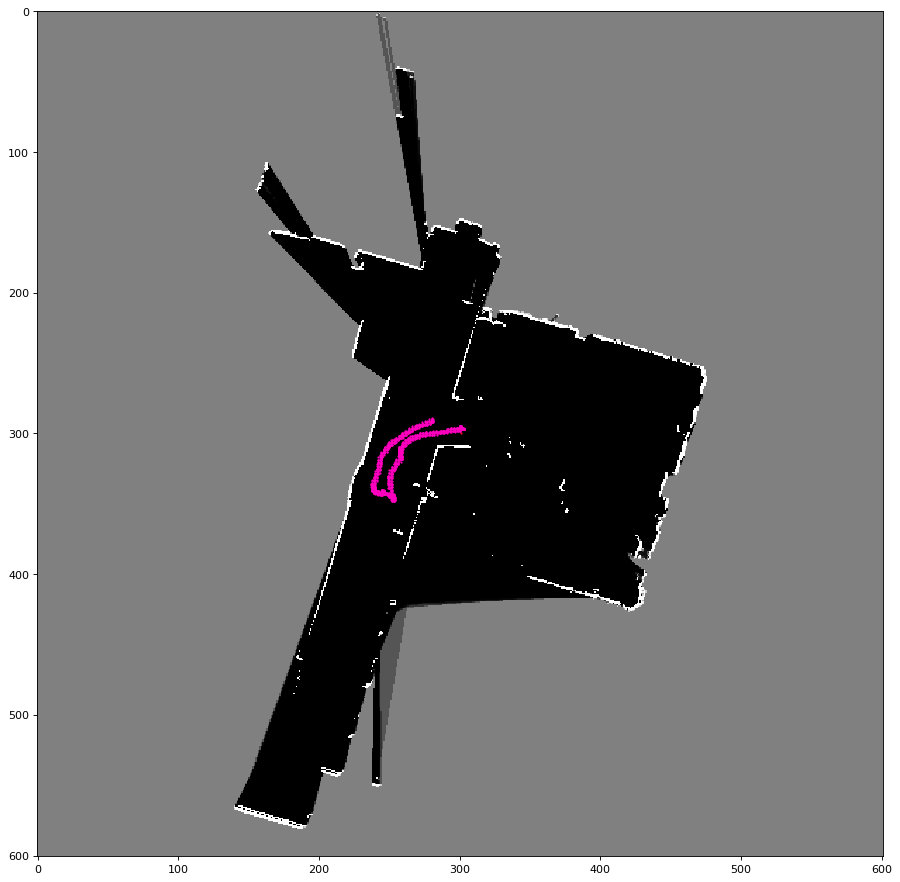

In [6]:
import pylab
indices = slam.coordinate_to_map_index(np.array(states))
plot_map(slam.map_prob, [indices[::5, 0], indices[::5, 1]], 20)

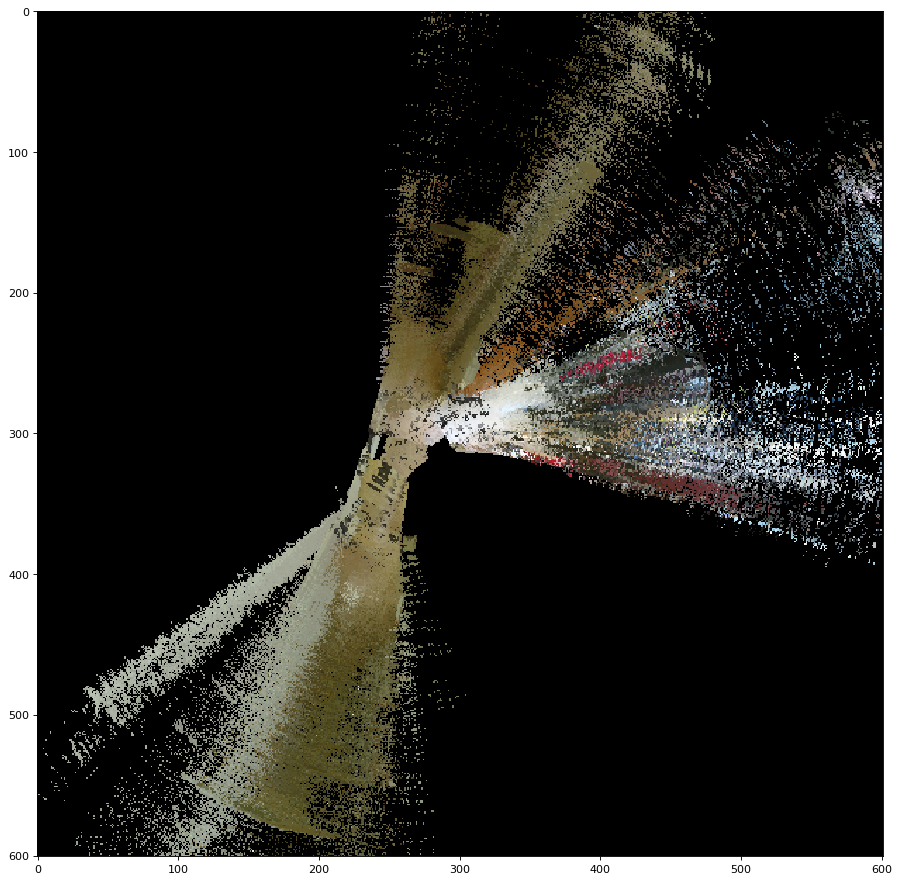

In [12]:
plot_map(slam.map_texture_raw)

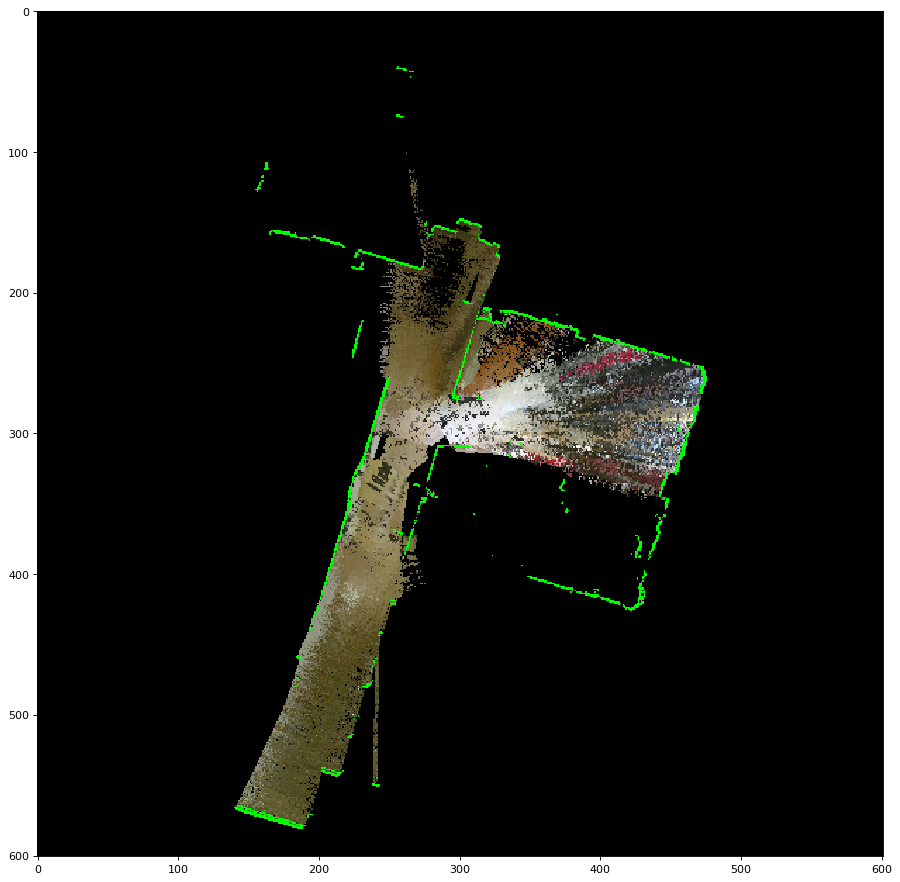

In [13]:
plot_map(slam.map_texture_trimmed)